**Warning:**

To run this notebook, the .ipynb file must be in the  project root directory.

In [2]:
import pandas as pd
import numpy as np
import json
import re
import os
import time
from langchain_google_genai import GoogleGenerativeAIEmbeddings
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score

In [3]:
# Threshold for considering a symptom captured in the anamnesis via embeddings
SYMPTOM_SIMILARITY_THRESHOLD = 0.81

QUOTA_TIER_TIMEOUT = 10  # seconds to wait if quota tier limit is hit
embeddings_model = GoogleGenerativeAIEmbeddings(
    model="models/gemini-embedding-001",
    temperature=0,
    max_tokens=1536,
    max_retries=2,
    timeout=None,
)

In [4]:
# Blackwell evaluation outputs
reports = pd.read_csv("evaluation/evaluator_output.csv")
# Gemini (Raw) outputs
raw_eval = pd.read_csv("evaluation/evaluator_raw.csv")
# Gemini (w/Anamnesis) outputs
gai_eval = pd.read_csv("evaluation/evaluator_stock.csv")
print("Blackwell reports loaded:", len(reports))
print("Gemini (Raw) reports loaded:", len(raw_eval))
print("Gemini (w/Anamnesis) reports loaded:", len(gai_eval))

Blackwell reports loaded: 250
Gemini (Raw) reports loaded: 100
Gemini (w/Anamnesis) reports loaded: 200


## Additional Functions

In [5]:
#Best-effort helper to embed a list of texts with Gemini
def embed_texts(texts):
    cleaned = [t.strip() for t in texts if isinstance(t, str) and t.strip()]
    if not cleaned:
        return []
    try:
        return embeddings_model.embed_documents(cleaned)
    except Exception as exc:
        print(f"Embedding call failed for {len(cleaned)} texts: {exc}")
        return []


In [6]:
# Calculate symptom recall based on anamnesis report and patient profile
def calculate_symptom_recall(anamnesis_report, patient_profile):
    anamnesis_report = json.loads(anamnesis_report)
    symptoms = json.loads(patient_profile)
    true_symptoms = [k.replace('_', ' ') for k, v in symptoms.items() if v != 0]

    if not true_symptoms or not anamnesis_report.strip():
        raise ValueError(f"Error - No symptoms to report or no anamnesis to compare")

    report_spans = [segment.strip() for segment in re.split(r'[.;\n]', anamnesis_report) if segment.strip()]
    if not report_spans:
        report_spans = [anamnesis_report.strip()]

    symptom_embeddings = np.asarray(embed_texts(true_symptoms), dtype=float)
    report_embeddings = np.asarray(embed_texts(report_spans), dtype=float)

    if symptom_embeddings.size == 0 or report_embeddings.size == 0:
        raise ValueError(f"Error - No embeddings generated for symptoms or report")

    report_norms = np.linalg.norm(report_embeddings, axis=1)
    report_norms = np.where(report_norms == 0, 1e-10, report_norms)

    detected_count = 0
    non_detected_symptoms = []
    for idx, symptom_vector in enumerate(symptom_embeddings):
        symptom_norm = np.linalg.norm(symptom_vector)
        if symptom_norm == 0:
            continue
        cosine_scores = (report_embeddings @ symptom_vector) / (report_norms * symptom_norm)
        
        if np.max(cosine_scores) >= SYMPTOM_SIMILARITY_THRESHOLD:
            detected_count += 1
        else:
            non_detected_symptoms.append(true_symptoms[idx])

    recall = detected_count / len(true_symptoms)
    return recall, non_detected_symptoms

# Anamnesis Analysis

## Emergency Detection Analysis

In [64]:
# List of symptoms considered emergencies
EMERGENCY_SYMPTOMS = [
    "chest_pain",
    "breathlessness",
    "altered_sensorium",
    "stomach_bleeding",
    "blood_in_sputum",
    "slurred_speech",
    "weakness_of_one_body_side",
    "loss_of_balance"
]

In [66]:
def check_emergency_symptoms(patient_profile):
    """
    Check if the patient profile contains any emergency symptoms.
    Returns a tuple: (has_emergency_symptoms, list of emergency symptoms present)
    """
    symptoms = json.loads(patient_profile)
    present_emergency_symptoms = [
        s.replace('_', ' ') for s in EMERGENCY_SYMPTOMS 
        if symptoms.get(s, 0) != 0
    ]
    return len(present_emergency_symptoms) > 0, present_emergency_symptoms

def analyze_emergency_detection(row):
    """
    Analyzes whether the emergency detection was appropriate based on symptoms.
    
    Returns a dict with:
    - emergency_detected: bool - whether "EMERGENCY DETECTED" appears in anamnesis
    - has_emergency_symptoms: bool - whether patient had emergency symptoms
    - emergency_symptoms: list - which emergency symptoms were present
    - classification: str - TP/FP/TN/FN based on symptom-level analysis
    - true_condition: str - the ground truth condition (for context only)
    """
    anamnesis_text = str(row.get('anamnesis_report', ''))
    emergency_detected = "EMERGENCY DETECTED" in anamnesis_text
    
    has_emergency_symptoms, present_symptoms = check_emergency_symptoms(row['patient_profile'])
    
    if emergency_detected and has_emergency_symptoms:
        classification = "TP"  # Correctly detected emergency symptoms
    elif emergency_detected and not has_emergency_symptoms:
        classification = "FP"  # False alarm - no emergency symptoms but aborted
    elif not emergency_detected and has_emergency_symptoms:
        classification = "FN"  # Missed - had emergency symptoms but wasn't flagged
    else:
        classification = "TN"  # Correctly processed non-emergency case
    
    return {
        'emergency_detected': emergency_detected,
        'has_emergency_symptoms': has_emergency_symptoms,
        'emergency_symptoms': present_symptoms,
        'classification': classification,
        'true_condition': row['true_condition']
    }

In [67]:
# Run emergency analysis
print("Analyzing Emergency Detection (Symptom-Based)...")
emergency_analysis = pd.DataFrame([analyze_emergency_detection(reports.iloc[i]) for i in range(len(reports))])

classification_counts = emergency_analysis['classification'].value_counts()
print("\nClassification Results:")
for cls in ['TP', 'TN', 'FP', 'FN']:
    count = classification_counts.get(cls, 0)
    print(f"  {cls}: {count}")

# Calculate metrics
tp = classification_counts.get('TP', 0)
tn = classification_counts.get('TN', 0)
fp = classification_counts.get('FP', 0)
fn = classification_counts.get('FN', 0)

total = tp + tn + fp + fn
accuracy = (tp + tn) / total if total > 0 else 0
precision = tp / (tp + fp) if (tp + fp) > 0 else 0
recall = tp / (tp + fn) if (tp + fn) > 0 else 0
f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0

print(f"\nPerformance Metrics:")
print(f"  Accuracy:  {accuracy:.2%}")
print(f"  Precision: {precision:.2%}")
print(f"  Recall:    {recall:.2%}")
print(f"  F1 Score:  {f1:.2%}")

print(f"\nTotal cases with emergency symptoms: {(emergency_analysis['has_emergency_symptoms']).sum()}")
print(f"Total cases where emergency was detected: {(emergency_analysis['emergency_detected']).sum()}")


Analyzing Emergency Detection (Symptom-Based)...

EMERGENCY DETECTION ANALYSIS (Symptom-Based)

Classification Results:
  TP: 41
  TN: 154
  FP: 28
  FN: 27

Performance Metrics:
  Accuracy:  78.00%
  Precision: 59.42%
  Recall:    60.29%
  F1 Score:  59.85%

Total cases with emergency symptoms: 68
Total cases where emergency was detected: 69


In [70]:
# Show False Negatives (missed emergencies) - most critical
fn_cases = emergency_analysis[emergency_analysis['classification'] == 'FN']
if len(fn_cases) > 0:
    print(f"\nFALSE NEGATIVES (Missed Emergencies): {len(fn_cases)} cases")
    for idx, row in fn_cases.iterrows():
        print(f"    Case {idx}: {row['true_condition']}")
        print(f"      Emergency symptoms present: {', '.join(row['emergency_symptoms'])}")

# Show True Positives (correctly detected)
tp_cases = emergency_analysis[emergency_analysis['classification'] == 'TP']
if len(tp_cases) > 0:
    print(f"\nTRUE POSITIVES (Correctly Detected): {len(tp_cases)} cases")
    for idx, row in tp_cases.iterrows():
        print(f"    Case {idx}: {row['true_condition']}")
        print(f"      Emergency symptoms: {', '.join(row['emergency_symptoms'])}")

# Show False Positives (false alarms)
fp_cases = emergency_analysis[emergency_analysis['classification'] == 'FP']
if len(fp_cases) > 0:
    print(f"\nFALSE POSITIVES (False Alarms): {len(fp_cases)} cases")
    print("    These cases were flagged as emergencies but had NO emergency symptoms:")
    for idx, row in fp_cases.iterrows():
        print(f"    Case {idx}: {row['true_condition']}")

# Count which emergency symptoms are most common
all_emergency_symptoms = []
for symptoms_list in emergency_analysis['emergency_symptoms']:
    all_emergency_symptoms.extend(symptoms_list)

if all_emergency_symptoms:
    symptom_counts = pd.Series(all_emergency_symptoms).value_counts()
    print(f"\nMost Common Emergency Symptoms in Dataset:")
    for symptom, count in symptom_counts.head(10).items():
        print(f"    {symptom}: {count} cases")


FALSE NEGATIVES (Missed Emergencies): 27 cases
    Case 6: Common Cold
      Emergency symptoms present: chest pain
    Case 31: Pneumonia
      Emergency symptoms present: chest pain, breathlessness
    Case 37: GERD
      Emergency symptoms present: chest pain
    Case 46: Cervical spondylosis
      Emergency symptoms present: loss of balance
    Case 52: Common Cold
      Emergency symptoms present: chest pain
    Case 57: (vertigo) Paroymsal  Positional Vertigo
      Emergency symptoms present: loss of balance
    Case 60: Hypoglycemia
      Emergency symptoms present: slurred speech
    Case 81: GERD
      Emergency symptoms present: chest pain
    Case 84: (vertigo) Paroymsal  Positional Vertigo
      Emergency symptoms present: loss of balance
    Case 104: Hypoglycemia
      Emergency symptoms present: slurred speech
    Case 112: Cervical spondylosis
      Emergency symptoms present: loss of balance
    Case 124: Cervical spondylosis
      Emergency symptoms present: loss of 

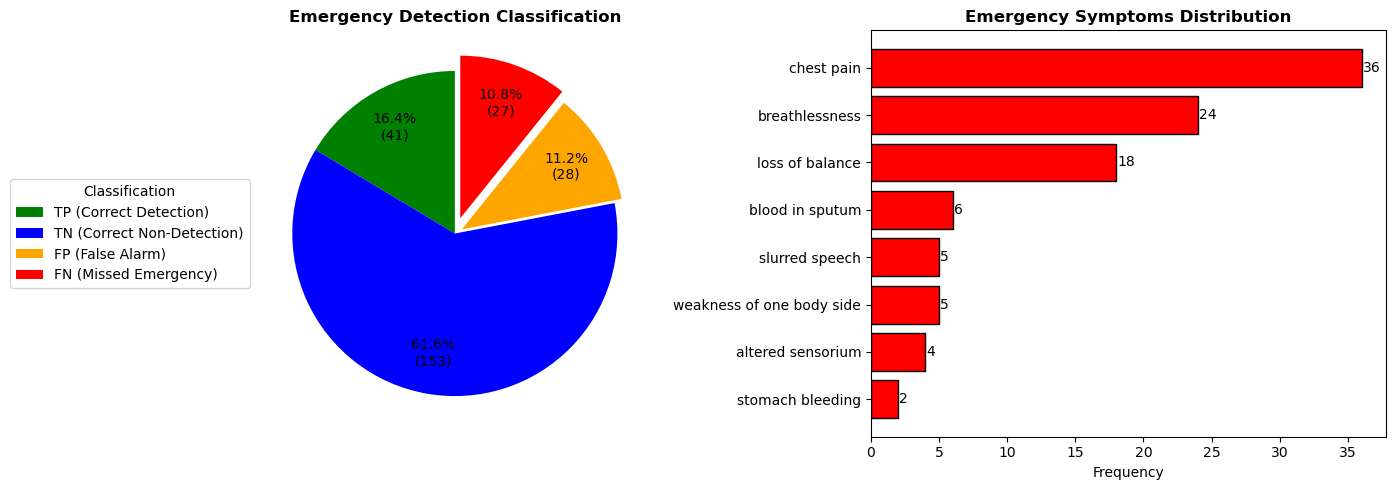

In [74]:
# Emergency Detection Visualizations
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Classification Confusion Matrix Style (Pie Chart)
classification_counts = emergency_analysis['classification'].value_counts()
colors_map = {'TP': 'green', 'TN': 'blue', 'FP': 'orange', 'FN': 'red'}
labels = ['TP (Correct Detection)', 'TN (Correct Non-Detection)', 
          'FP (False Alarm)', 'FN (Missed Emergency)']
sizes = [classification_counts.get(c, 0) for c in ['TP', 'TN', 'FP', 'FN']]
colors = [colors_map[c] for c in ['TP', 'TN', 'FP', 'FN']]
explode = (0, 0, 0.05, 0.1)  # Emphasize FP and FN

wedges, texts, autotexts = axes[0].pie(
    sizes, explode=explode, labels=None, colors=colors,
    autopct=lambda p: f'{p:.1f}%\n({int(p*sum(sizes)/100)})',
    startangle=90, pctdistance=0.75
)
axes[0].legend(wedges, labels, title="Classification", loc="center", bbox_to_anchor=(-0.3, 0.5))
axes[0].set_title("Emergency Detection Classification", fontsize=12, fontweight='bold')



# 3. Emergency symptoms frequency (for cases that had them)
all_symptoms = []
for symptoms_list in emergency_analysis['emergency_symptoms']:
    all_symptoms.extend(symptoms_list)

if all_symptoms:
    symptom_freq = pd.Series(all_symptoms).value_counts()
    bars = axes[1].barh(symptom_freq.index, symptom_freq.values, color='red', edgecolor='black')
    axes[1].set_xlabel("Frequency")
    axes[1].set_title("Emergency Symptoms Distribution", fontsize=12, fontweight='bold')
    axes[1].invert_yaxis()
    for bar, count in zip(bars, symptom_freq.values):
        axes[1].text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2, 
                        str(count), va='center', fontsize=10)
else:
    axes[1].text(0.5, 0.5, "No emergency symptoms\nin dataset", ha='center', va='center', fontsize=12)
    axes[1].set_title("Emergency Symptoms Distribution", fontsize=12, fontweight='bold')


plt.tight_layout()
plt.savefig("evaluation/Images/anamnesis-analysis/emergency_detection_analysis.png", dpi=300, bbox_inches='tight')
plt.show()

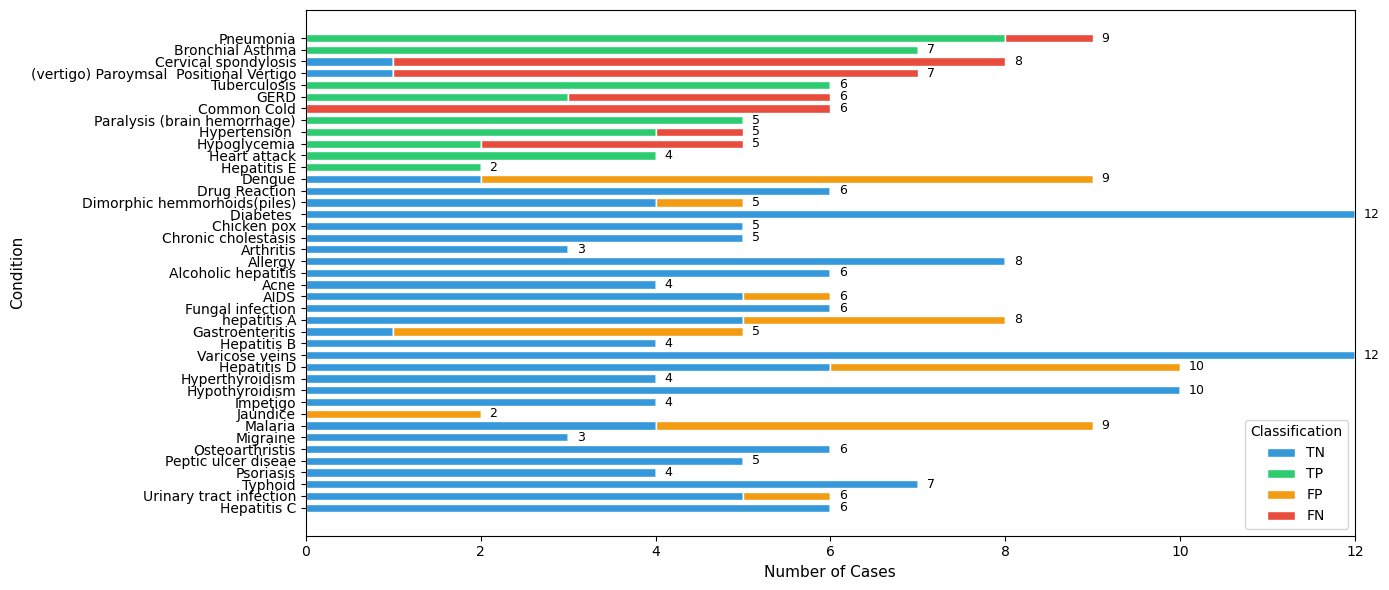

In [77]:
# Emergency Detection by Condition - Stacked Bar Chart
fig, ax = plt.subplots(figsize=(14, 6))

# Group by condition and classification
condition_class = emergency_analysis.groupby(['true_condition', 'classification']).size().unstack(fill_value=0)

# Ensure all classification columns exist
for col in ['TP', 'TN', 'FP', 'FN']:
    if col not in condition_class.columns:
        condition_class[col] = 0

# Reorder columns for consistent stacking
condition_class = condition_class[['TP', 'TN', 'FP', 'FN']]

# Sort by total cases with emergency symptoms (TP + FN)
condition_class['emergency_cases'] = condition_class['TP'] + condition_class['FN']
condition_class = condition_class.sort_values('emergency_cases', ascending=True)
condition_class = condition_class.drop('emergency_cases', axis=1)

# Create stacked bar chart
colors_map = {'TP': '#2ecc71', 'TN': '#3498db', 'FP': '#f39c12', 'FN': '#e74c3c'}
bottom = np.zeros(len(condition_class))

for cls in ['TN', 'TP', 'FP', 'FN']:
    values = condition_class[cls].values
    ax.barh(condition_class.index, values, left=bottom, 
            label=cls, color=colors_map[cls], edgecolor='white', height=0.7)
    bottom += values

ax.set_xlabel("Number of Cases", fontsize=11)
ax.set_ylabel("Condition", fontsize=11)
#ax.set_title("Emergency Detection Classification by Condition", fontsize=13, fontweight='bold')
ax.legend(title="Classification", loc='lower right')

# Add total count labels
for i, (idx, row) in enumerate(condition_class.iterrows()):
    total = row.sum()
    ax.text(total + 0.1, i, f'{int(total)}', va='center', fontsize=9)

plt.tight_layout()
plt.savefig("evaluation/Images/anamnesis-analysis/emergency_by_condition.png", dpi=300, bbox_inches='tight')
plt.show()
 

### Performance Summary

In [82]:
# Anamnesis Exchange Analysis
# Analyze the number of conversational exchanges for anamnesis completion

# Create exchange analysis dataframe
exchange_analysis = reports[['true_condition', 'exchanges']].copy()
exchange_analysis['emergency_detected'] = emergency_analysis['emergency_detected'].values
exchange_analysis['has_emergency_symptoms'] = emergency_analysis['has_emergency_symptoms'].values
exchange_analysis['classification'] = emergency_analysis['classification'].values

print("ANAMNESIS EXCHANGE ANALYSIS")

# Overall statistics
print(f"\nOverall Statistics:")
print(f"  Total cases: {len(reports)}")
print(f"  Average exchanges: {reports['exchanges'].mean():.2f}")
print(f"  Min exchanges: {reports['exchanges'].min()}")
print(f"  Max exchanges: {reports['exchanges'].max()}")
print(f"  Median exchanges: {reports['exchanges'].median():.0f}")

# Separate by emergency detection (how the agent concluded)
emergency_detected = exchange_analysis[exchange_analysis['emergency_detected'] == True]
normal_completed = exchange_analysis[exchange_analysis['emergency_detected'] == False]


print("\nBY COMPLETION TYPE (How Agent Concluded):")

print(f"\n  Normal Anamnesis Completion (no emergency detected):")
print(f"    Cases: {len(normal_completed)}")
if len(normal_completed) > 0:
    print(f"    Average exchanges: {normal_completed['exchanges'].mean():.2f}")
    print(f"    Min/Max: {normal_completed['exchanges'].min()} / {normal_completed['exchanges'].max()}")
    print(f"    Median: {normal_completed['exchanges'].median():.0f}")

print(f"\n  Emergency Detection (emergency flagged):")
print(f"    Cases: {len(emergency_detected)}")
if len(emergency_detected) > 0:
    print(f"    Average exchanges: {emergency_detected['exchanges'].mean():.2f}")
    print(f"    Min/Max: {emergency_detected['exchanges'].min()} / {emergency_detected['exchanges'].max()}")
    print(f"    Median: {emergency_detected['exchanges'].median():.0f}")

ANAMNESIS EXCHANGE ANALYSIS

Overall Statistics:
  Total cases: 250
  Average exchanges: 18.19
  Min exchanges: 4
  Max exchanges: 34
  Median exchanges: 20

BY COMPLETION TYPE (How Agent Concluded):

  Normal Anamnesis Completion (no emergency detected):
    Cases: 181
    Average exchanges: 21.89
    Min/Max: 14 / 34
    Median: 22

  Emergency Detection (emergency flagged):
    Cases: 69
    Average exchanges: 8.49
    Min/Max: 4 / 24
    Median: 8


C:\Users\lukas\AppData\Local\Temp\ipykernel_20904\4027221504.py:37: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = axes[1].boxplot(box_data, labels=box_labels, patch_artist=True, widths=0.5)


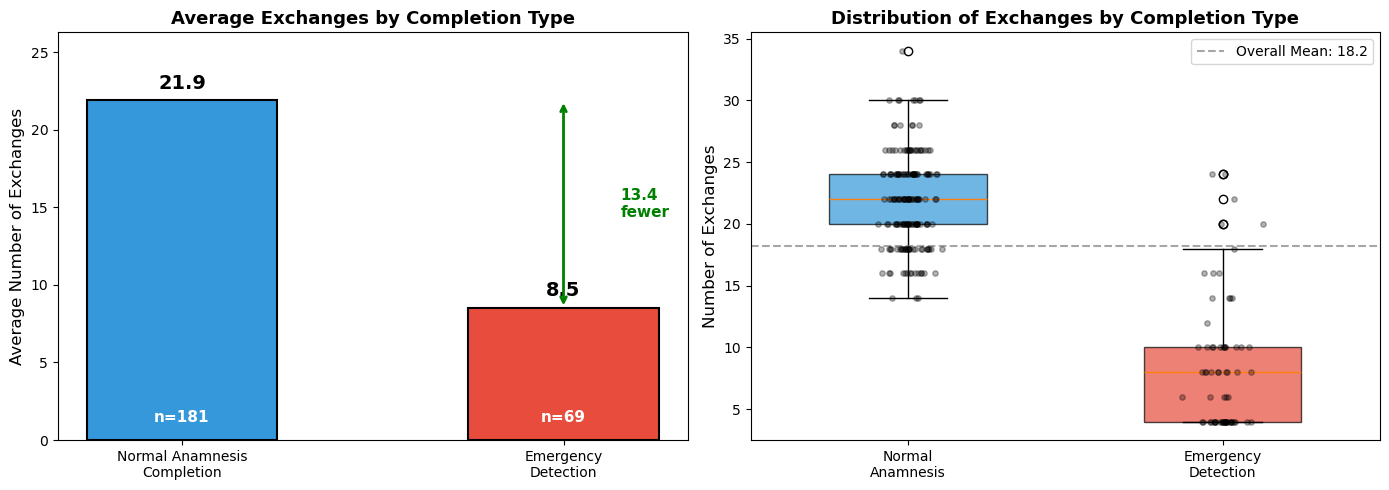

In [83]:
# Anamnesis Exchange Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 1. Average Exchanges by Completion Type
completion_types = ['Normal Anamnesis\nCompletion', 'Emergency\nDetection']
avg_exchanges = [normal_completed['exchanges'].mean(), emergency_detected['exchanges'].mean()]
colors = ['#3498db', '#e74c3c']

bars = axes[0].bar(completion_types, avg_exchanges, color=colors, edgecolor='black', linewidth=1.5, width=0.5)

# Add value labels
for bar, val in zip(bars, avg_exchanges):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                f'{val:.1f}', ha='center', va='bottom', fontsize=14, fontweight='bold')

# Add count labels
axes[0].text(bars[0].get_x() + bars[0].get_width()/2, 1,
            f'n={len(normal_completed)}', ha='center', va='bottom', fontsize=11, color='white', fontweight='bold')
axes[0].text(bars[1].get_x() + bars[1].get_width()/2, 1,
            f'n={len(emergency_detected)}', ha='center', va='bottom', fontsize=11, color='white', fontweight='bold')

axes[0].set_ylabel('Average Number of Exchanges', fontsize=12)
axes[0].set_title('Average Exchanges by Completion Type', fontweight='bold', fontsize=13)
axes[0].set_ylim(0, max(avg_exchanges) * 1.2)

# Add annotation for difference
diff = avg_exchanges[0] - avg_exchanges[1]
axes[0].annotate('', xy=(1, avg_exchanges[1]), xytext=(1, avg_exchanges[0]),
                arrowprops=dict(arrowstyle='<->', color='green', lw=2))
axes[0].text(1.15, (avg_exchanges[0] + avg_exchanges[1])/2, f'{diff:.1f}\nfewer',
            ha='left', va='center', fontsize=11, color='green', fontweight='bold')

# 2. Distribution of Exchanges (Box plot + Strip)
box_data = [normal_completed['exchanges'], emergency_detected['exchanges']]
box_labels = ['Normal\nAnamnesis', 'Emergency\nDetection']

bp = axes[1].boxplot(box_data, labels=box_labels, patch_artist=True, widths=0.5)
colors_box = ['#3498db', '#e74c3c']
for patch, color in zip(bp['boxes'], colors_box):
    patch.set_facecolor(color)
    patch.set_alpha(0.7)

# Add strip plot for individual points
for i, data in enumerate(box_data, 1):
    x = np.random.normal(i, 0.04, size=len(data))
    axes[1].scatter(x, data, alpha=0.3, color='black', s=15, zorder=3)

axes[1].set_ylabel('Number of Exchanges', fontsize=12)
axes[1].set_title('Distribution of Exchanges by Completion Type', fontweight='bold', fontsize=13)
axes[1].axhline(y=reports['exchanges'].mean(), color='gray', linestyle='--', alpha=0.7, 
                label=f'Overall Mean: {reports["exchanges"].mean():.1f}')
axes[1].legend(loc='upper right')

plt.tight_layout()
plt.savefig('evaluation/Images/anamnesis-analysis/anamnesis_exchanges.png', dpi=300, bbox_inches='tight')
plt.show()

The anamnesis agent is significantly more efficient when detecting emergencies:

- Normal anamnesis takes an average of 21.9 exchanges
- Emergency detection takes an average of 8.5 exchanges
- Emergency detection is 13.4 exchanges faster (61% reduction)

This is expected behavior - when the agent detects critical symptoms early in the 
conversation, it correctly prioritizes escalation over gathering complete medical history.

## Analysis of Non-Detected "Emergencies" (False Negatives)

This section examines the cases classified as False Negatives (FN) - where the system did not detect an emergency, but the patient had symptoms that matched our emergency symptom list. The key insight is that these "missed emergencies" were actually **non-emergency conditions** like Common Cold or Vertigo that happened to present with symptoms overlapping our emergency criteria.

In [88]:
# Analyze False Negatives - the "missed emergencies" that weren't actually emergencies
print("FALSE NEGATIVE ANALYSIS - 'Missed Emergencies' That Weren't Emergencies")

# Get FN cases
fn_cases = emergency_analysis[emergency_analysis['classification'] == 'FN'].copy()
print(f"\nTotal False Negatives: {len(fn_cases)} cases")

# Show the conditions in FN cases
fn_conditions = fn_cases['true_condition'].value_counts()
print(f"\nConditions in 'Missed' Emergency Cases:")
print("-" * 40)
for condition, count in fn_conditions.items():
    pct = count / len(fn_cases) * 100
    print(f"  {condition}: {count} cases ({pct:.1f}%)")

# These conditions are NOT true emergencies - they just happen to have overlapping symptoms
# Cervical spondylosis: neck pain can cause loss of balance but is not an emergency
# Common Cold: common illness, not an emergency
# Vertigo (BPPV): causes loss of balance but is not life-threatening
# GERD: causes chest pain but is not cardiac - not an emergency
# Hypoglycemia: can be managed at home in mild cases
NON_EMERGENCY_FN_CONDITIONS = [
    'Common Cold', 
    '(vertigo) Paroymsal  Positional Vertigo',  # BPPV
    'Cervical spondylosis',  # Neck issues causing balance problems
    'GERD',  # Chest pain from acid reflux, not cardiac
]

fn_non_emergency = fn_cases[fn_cases['true_condition'].isin(NON_EMERGENCY_FN_CONDITIONS)]
fn_potentially_serious = fn_cases[~fn_cases['true_condition'].isin(NON_EMERGENCY_FN_CONDITIONS)]

print("=" * 40)
print("\nRE-CLASSIFICATION OF FALSE NEGATIVES")
print(f"\n Actually NON-emergency conditions (symptom overlap): {len(fn_non_emergency)} cases ({len(fn_non_emergency)/len(fn_cases)*100:.1f}%)")
for condition in NON_EMERGENCY_FN_CONDITIONS:
    count = len(fn_cases[fn_cases['true_condition'] == condition])
    if count > 0:
        print(f"    - {condition}: {count} cases")
        
print(f"\n Conditions requiring further assessment: {len(fn_potentially_serious)} cases ({len(fn_potentially_serious)/len(fn_cases)*100:.1f}%)")
if len(fn_potentially_serious) > 0:
    for condition, count in fn_potentially_serious['true_condition'].value_counts().items():
        print(f"    - {condition}: {count}")

# Also show what symptoms triggered these FN classifications
print(f"\n" + "-" * 40)
print("Emergency symptoms that triggered FN classification:")
all_fn_symptoms = []
for symptoms_list in fn_cases['emergency_symptoms']:
    all_fn_symptoms.extend(symptoms_list)
fn_symptom_counts = pd.Series(all_fn_symptoms).value_counts()
for symptom, count in fn_symptom_counts.items():
    print(f"  {symptom}: {count} occurrences")

FALSE NEGATIVE ANALYSIS - 'Missed Emergencies' That Weren't Emergencies

Total False Negatives: 27 cases

Conditions in 'Missed' Emergency Cases:
----------------------------------------
  Cervical spondylosis: 7 cases (25.9%)
  Common Cold: 6 cases (22.2%)
  (vertigo) Paroymsal  Positional Vertigo: 6 cases (22.2%)
  GERD: 3 cases (11.1%)
  Hypoglycemia: 3 cases (11.1%)
  Pneumonia: 1 cases (3.7%)
  Hypertension : 1 cases (3.7%)

RE-CLASSIFICATION OF FALSE NEGATIVES

 Actually NON-emergency conditions (symptom overlap): 22 cases (81.5%)
    - Common Cold: 6 cases
    - (vertigo) Paroymsal  Positional Vertigo: 6 cases
    - Cervical spondylosis: 7 cases
    - GERD: 3 cases

 Conditions requiring further assessment: 5 cases (18.5%)
    - Hypoglycemia: 3
    - Pneumonia: 1
    - Hypertension : 1

----------------------------------------
Emergency symptoms that triggered FN classification:
  loss of balance: 14 occurrences
  chest pain: 11 occurrences
  slurred speech: 3 occurrences
  brea

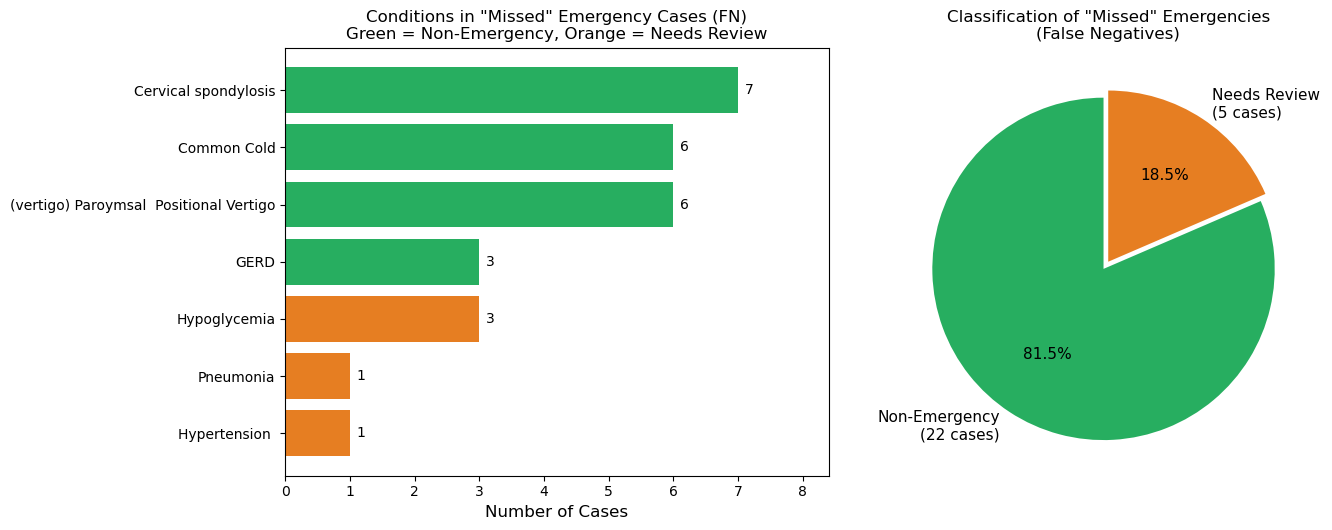

In [90]:
# Visualization: False Negatives - Showing that "missed" emergencies weren't actual emergencies
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 1. Bar chart of conditions in FN cases
ax1 = axes[0]
fn_conditions = fn_cases['true_condition'].value_counts()

# Color code: green for non-emergency, orange for potentially serious
colors = []
NON_EMERGENCY_FN_CONDITIONS = [
    'Common Cold', 
    '(vertigo) Paroymsal  Positional Vertigo',
    'Cervical spondylosis',
    'GERD',
]
for condition in fn_conditions.index:
    if condition in NON_EMERGENCY_FN_CONDITIONS:
        colors.append('#27ae60')  # Green - not an emergency
    else:
        colors.append('#e67e22')  # Orange - potentially concerning

bars = ax1.barh(range(len(fn_conditions)), fn_conditions.values, color=colors)
ax1.set_yticks(range(len(fn_conditions)))
ax1.set_yticklabels(fn_conditions.index)
ax1.invert_yaxis()
ax1.set_xlabel('Number of Cases', fontsize=12)
ax1.set_title('Conditions in "Missed" Emergency Cases (FN)\nGreen = Non-Emergency, Orange = Needs Review', fontsize=12)

# Add count labels
for i, (bar, count) in enumerate(zip(bars, fn_conditions.values)):
    ax1.text(bar.get_width() + 0.1, i, str(count), va='center', fontsize=10)

ax1.set_xlim(0, max(fn_conditions.values) * 1.2)

# 2. Pie chart showing proportion of actual non-emergencies vs potentially serious
ax2 = axes[1]
fn_non_emergency = fn_cases[fn_cases['true_condition'].isin(NON_EMERGENCY_FN_CONDITIONS)]
fn_potentially_serious = fn_cases[~fn_cases['true_condition'].isin(NON_EMERGENCY_FN_CONDITIONS)]

sizes = [len(fn_non_emergency), len(fn_potentially_serious)]
labels = [f'Non-Emergency\n({len(fn_non_emergency)} cases)', 
          f'Needs Review\n({len(fn_potentially_serious)} cases)']
colors_pie = ['#27ae60', '#e67e22']
explode = (0.05, 0)

wedges, texts, autotexts = ax2.pie(sizes, explode=explode, labels=labels, colors=colors_pie,
                                    autopct='%1.1f%%', startangle=90, 
                                    textprops={'fontsize': 11})
ax2.set_title('Classification of "Missed" Emergencies\n(False Negatives)', fontsize=12)

plt.tight_layout(rect=[0, 0.1, 1, 1])
plt.savefig("evaluation/Images/anamnesis-analysis/false_negative_analysis.png", dpi=300, bbox_inches='tight')
plt.show()

In [98]:
# Emergency Detection Dashboard - RECLASSIFYING Non-Emergency Conditions
# Conditions that present with emergency-like symptoms but aren't actual emergencies
# These should be reclassified as True Negatives (correct to NOT flag them as emergencies)
NON_EMERGENCY_FN_CONDITIONS = [
    'Common Cold', 
    '(vertigo) Paroymsal  Positional Vertigo',
    'Cervical spondylosis',
    'GERD',
]

# Create adjusted emergency analysis - reclassify FN for non-emergency conditions as TN
emergency_filtered = emergency_analysis.copy()

# Cases that were classified as FN but are actually non-emergency conditions should be TN
mask_reclassify = (
    (emergency_filtered['classification'] == 'FN') & 
    (emergency_filtered['true_condition'].isin(NON_EMERGENCY_FN_CONDITIONS))
)
reclassified_count = mask_reclassify.sum()
emergency_filtered.loc[mask_reclassify, 'classification'] = 'TN'

print(f"Total cases: {len(emergency_filtered)}")
print(f"Reclassified {reclassified_count} cases from FN to TN (non-emergency conditions)")

# Recalculate metrics with reclassified data
tp_filtered = len(emergency_filtered[(emergency_filtered['classification'] == 'TP')])
tn_filtered = len(emergency_filtered[(emergency_filtered['classification'] == 'TN')])
fp_filtered = len(emergency_filtered[(emergency_filtered['classification'] == 'FP')])
fn_filtered = len(emergency_filtered[(emergency_filtered['classification'] == 'FN')])

total_filtered = len(emergency_filtered)
accuracy_filtered = (tp_filtered + tn_filtered) / total_filtered if total_filtered > 0 else 0
precision_filtered = tp_filtered / (tp_filtered + fp_filtered) if (tp_filtered + fp_filtered) > 0 else 0
recall_filtered = tp_filtered / (tp_filtered + fn_filtered) if (tp_filtered + fn_filtered) > 0 else 0
f1_filtered = 2 * (precision_filtered * recall_filtered) / (precision_filtered + recall_filtered) if (precision_filtered + recall_filtered) > 0 else 0

print(f"\nAdjusted Metrics:")
print(f"  TP: {tp_filtered}, TN: {tn_filtered}, FP: {fp_filtered}, FN: {fn_filtered}")
print(f"  Accuracy: {accuracy_filtered:.1%}")
print(f"  Precision: {precision_filtered:.1%}")
print(f"  Recall: {recall_filtered:.1%}")
print(f"  F1: {f1_filtered:.1%}")

Total cases: 250
Reclassified 22 cases from FN to TN (non-emergency conditions)

Adjusted Metrics:
  TP: 41, TN: 176, FP: 28, FN: 5
  Accuracy: 86.8%
  Precision: 59.4%
  Recall: 89.1%
  F1: 71.3%


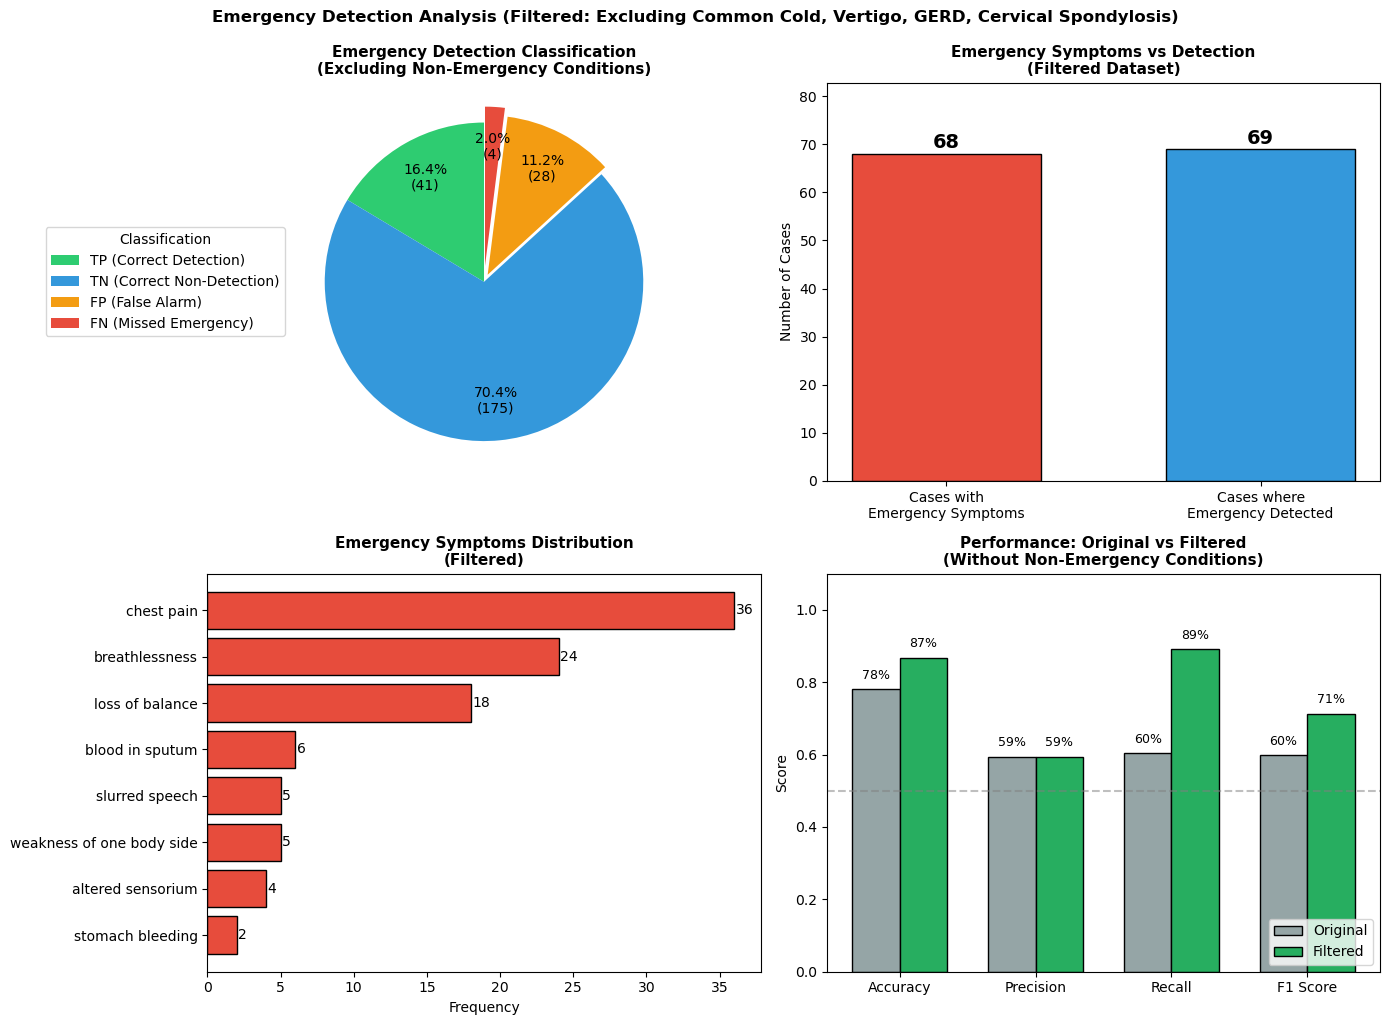


 PERFORMANCE IMPROVEMENT AFTER FILTERING:
   Accuracy: 78.0% → 86.8% (+8.8pp)
   Precision: 59.4% → 59.4% (+0.0pp)
   Recall: 60.3% → 89.1% (+28.8pp)
   F1 Score: 59.9% → 71.3% (+11.5pp)


In [100]:
# Emergency Detection Dashboard (Filtered - Excluding Non-Emergency Conditions)
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Classification Pie Chart (Filtered)
classification_counts_filtered = emergency_filtered['classification'].value_counts()
colors_map = {'TP': '#2ecc71', 'TN': '#3498db', 'FP': '#f39c12', 'FN': '#e74c3c'}
labels = ['TP (Correct Detection)', 'TN (Correct Non-Detection)', 
          'FP (False Alarm)', 'FN (Missed Emergency)']
sizes = [classification_counts_filtered.get(c, 0) for c in ['TP', 'TN', 'FP', 'FN']]
colors = [colors_map[c] for c in ['TP', 'TN', 'FP', 'FN']]
explode = (0, 0, 0.05, 0.1)

wedges, texts, autotexts = axes[0, 0].pie(
    sizes, explode=explode, labels=None, colors=colors,
    autopct=lambda p: f'{p:.1f}%\n({int(p*sum(sizes)/100)})',
    startangle=90, pctdistance=0.75
)
axes[0, 0].legend(wedges, labels, title="Classification", loc="center", bbox_to_anchor=(-0.3, 0.5))
axes[0, 0].set_title("Emergency Detection Classification\n(Excluding Non-Emergency Conditions)", fontsize=11, fontweight='bold')

# 2. Bar chart comparing detection vs actual emergencies (Filtered)
categories = ['Cases with\nEmergency Symptoms', 'Cases where\nEmergency Detected']
values = [
    emergency_filtered['has_emergency_symptoms'].sum(),
    emergency_filtered['emergency_detected'].sum()
]
bar_colors = ['#e74c3c', '#3498db']
bars = axes[0, 1].bar(categories, values, color=bar_colors, edgecolor='black', width=0.6)
for bar, val in zip(bars, values):
    axes[0, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3, 
                    str(val), ha='center', va='bottom', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel("Number of Cases")
axes[0, 1].set_title("Emergency Symptoms vs Detection\n(Filtered Dataset)", fontsize=11, fontweight='bold')
axes[0, 1].set_ylim(0, max(values) * 1.2)

# 3. Emergency symptoms frequency (Filtered)
all_symptoms_filtered = []
for symptoms_list in emergency_filtered['emergency_symptoms']:
    all_symptoms_filtered.extend(symptoms_list)

if all_symptoms_filtered:
    symptom_freq_filtered = pd.Series(all_symptoms_filtered).value_counts()
    bars = axes[1, 0].barh(symptom_freq_filtered.index, symptom_freq_filtered.values, color='#e74c3c', edgecolor='black')
    axes[1, 0].set_xlabel("Frequency")
    axes[1, 0].set_title("Emergency Symptoms Distribution\n(Filtered)", fontsize=11, fontweight='bold')
    axes[1, 0].invert_yaxis()
    for bar, count in zip(bars, symptom_freq_filtered.values):
        axes[1, 0].text(bar.get_width() + 0.1, bar.get_y() + bar.get_height()/2, 
                        str(count), va='center', fontsize=10)
else:
    axes[1, 0].text(0.5, 0.5, "No emergency symptoms\nin filtered dataset", ha='center', va='center', fontsize=12)
    axes[1, 0].set_title("Emergency Symptoms Distribution", fontsize=11, fontweight='bold')

# 4. Performance Metrics Comparison (Original vs Filtered)
metrics_original = {'Accuracy': accuracy, 'Precision': precision, 'Recall': recall, 'F1 Score': f1}
metrics_filtered = {'Accuracy': accuracy_filtered, 'Precision': precision_filtered, 'Recall': recall_filtered, 'F1 Score': f1_filtered}

x = np.arange(len(metrics_original))
width = 0.35

bars1 = axes[1, 1].bar(x - width/2, list(metrics_original.values()), width, label='Original', color='#95a5a6', edgecolor='black')
bars2 = axes[1, 1].bar(x + width/2, list(metrics_filtered.values()), width, label='Filtered', color='#27ae60', edgecolor='black')

axes[1, 1].set_ylabel('Score')
axes[1, 1].set_title('Performance: Original vs Filtered\n(Without Non-Emergency Conditions)', fontsize=11, fontweight='bold')
axes[1, 1].set_xticks(x)
axes[1, 1].set_xticklabels(list(metrics_original.keys()))
axes[1, 1].legend(loc='lower right')
axes[1, 1].set_ylim(0, 1.1)
axes[1, 1].axhline(y=0.5, color='gray', linestyle='--', alpha=0.5)

# Add value labels
for bar in bars1:
    height = bar.get_height()
    axes[1, 1].text(bar.get_x() + bar.get_width()/2., height + 0.02,
                    f'{height:.0%}', ha='center', va='bottom', fontsize=9)
for bar in bars2:
    height = bar.get_height()
    axes[1, 1].text(bar.get_x() + bar.get_width()/2., height + 0.02,
                    f'{height:.0%}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.suptitle("Emergency Detection Analysis (Filtered: Excluding Common Cold, Vertigo, GERD, Cervical Spondylosis)", 
             fontsize=12, fontweight='bold', y=1.02)
plt.show()

# Print improvement summary
print(f"\n PERFORMANCE IMPROVEMENT AFTER FILTERING:")
print(f"   Accuracy: {accuracy:.1%} → {accuracy_filtered:.1%} ({(accuracy_filtered-accuracy)*100:+.1f}pp)")
print(f"   Precision: {precision:.1%} → {precision_filtered:.1%} ({(precision_filtered-precision)*100:+.1f}pp)")
print(f"   Recall: {recall:.1%} → {recall_filtered:.1%} ({(recall_filtered-recall)*100:+.1f}pp)")
print(f"   F1 Score: {f1:.1%} → {f1_filtered:.1%} ({(f1_filtered-f1)*100:+.1f}pp)")

## Symptom Recall Analysis

### Procedural

In [101]:
least_detected_symptoms = {}
analysis = pd.DataFrame(columns=["case_index", "recall", "non_detected_symptoms", "true_condition"])

# Iterate through each anamnesis report and calculate symptom recall
for i in range(len(reports)):
    if "EMERGENCY DETECTED" in reports.loc[i, "anamnesis_report"]:
        continue
    recall, non_detected_symptoms = calculate_symptom_recall(reports.loc[i, "anamnesis_report"], reports.loc[i, "patient_profile"])
    
    for symptom in non_detected_symptoms:
        if symptom not in least_detected_symptoms:
            least_detected_symptoms[symptom] = 1
        else:
            least_detected_symptoms[symptom] += 1
    
    analysis.loc[len(analysis)] = {
        "case_index": i,
        "recall": recall,
        "non_detected_symptoms": non_detected_symptoms,
        "true_condition": reports.loc[i, "true_condition"]
    }

In [105]:
# 6. Summary Statistics
print(f"Total cases analyzed: {len(analysis)}")
print(f"Mean recall: {analysis['recall'].mean():.2%}")
print(f"Median recall: {analysis['recall'].median():.2%}")
print(f"Std deviation: {analysis['recall'].std():.2%}")
print(f"Min recall: {analysis['recall'].min():.2%}")
print(f"Max recall: {analysis['recall'].max():.2%}")
print(f"\nCases with perfect recall (100%): {(analysis['recall'] == 1.0).sum()}")
print(f"Cases with recall >= 80%: {(analysis['recall'] >= 0.8).sum()}")
print(f"Cases with recall < 50%: {(analysis['recall'] < 0.5).sum()}")
print(f"\nDengue Average Recall: {analysis[analysis['true_condition'] == 'Dengue']['recall'].mean():.2%}")
print(f"\nTotal unique symptoms missed: {len(least_detected_symptoms)}")
print(f"Most frequently missed symptom: {max(least_detected_symptoms, key=least_detected_symptoms.get)} ({max(least_detected_symptoms.values())} times)")

Total cases analyzed: 181
Mean recall: 84.06%
Median recall: 85.71%
Std deviation: 16.32%
Min recall: 35.71%
Max recall: 100.00%

Cases with perfect recall (100%): 69
Cases with recall >= 80%: 121
Cases with recall < 50%: 6

Dengue Average Recall: 52.47%

Total unique symptoms missed: 75
Most frequently missed symptom: obesity (12 times)


### Visualizations

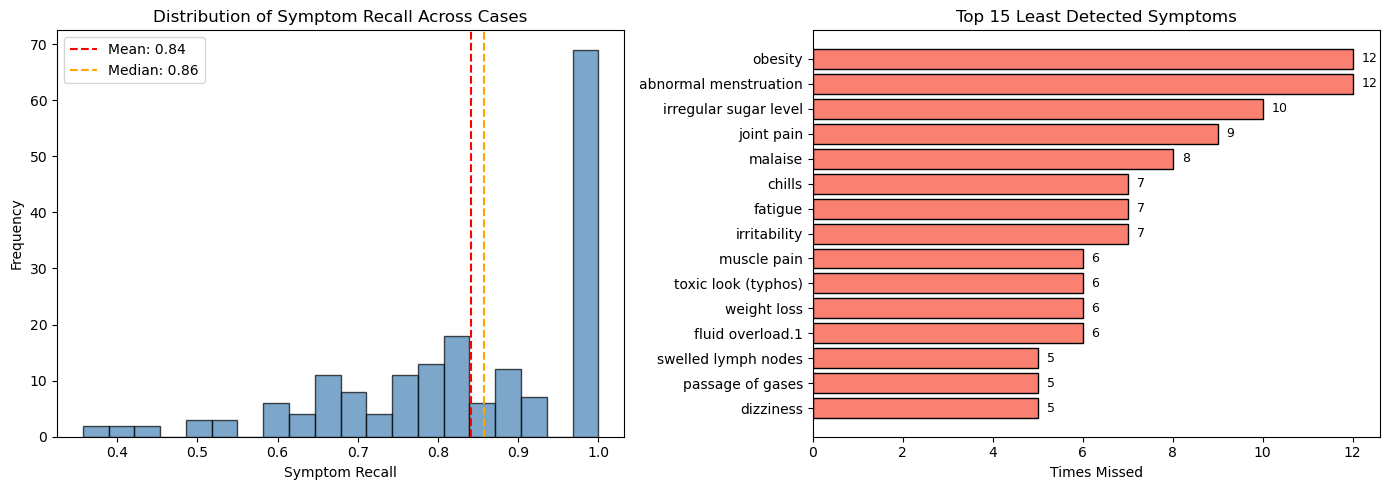

In [102]:
# 1. Recall Distribution Histogram
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Histogram of recall scores
axes[0].hist(analysis["recall"], bins=20, color="steelblue", edgecolor="black", alpha=0.7)
axes[0].axvline(analysis["recall"].mean(), color="red", linestyle="--", label=f"Mean: {analysis['recall'].mean():.2f}")
axes[0].axvline(analysis["recall"].median(), color="orange", linestyle="--", label=f"Median: {analysis['recall'].median():.2f}")
axes[0].set_xlabel("Symptom Recall")
axes[0].set_ylabel("Frequency")
axes[0].set_title("Distribution of Symptom Recall Across Cases")
axes[0].legend()
# 2. Top 15 Least Detected Symptoms (horizontal bar)
sorted_symptoms = dict(sorted(least_detected_symptoms.items(), key=lambda x: x[1], reverse=True)[:15])
bars = axes[1].barh(list(sorted_symptoms.keys()), list(sorted_symptoms.values()), color="salmon", edgecolor="black")
axes[1].set_xlabel("Times Missed")
axes[1].set_title("Top 15 Least Detected Symptoms")
axes[1].invert_yaxis()
for bar, count in zip(bars, sorted_symptoms.values()):
    axes[1].text(bar.get_width() + 0.2, bar.get_y() + bar.get_height()/2, str(count), va="center", fontsize=9)

plt.tight_layout()
plt.savefig("evaluation/Images/anamnesis-analysis/symptom_recall_analysis-1.png", dpi=300, bbox_inches="tight")
plt.show()

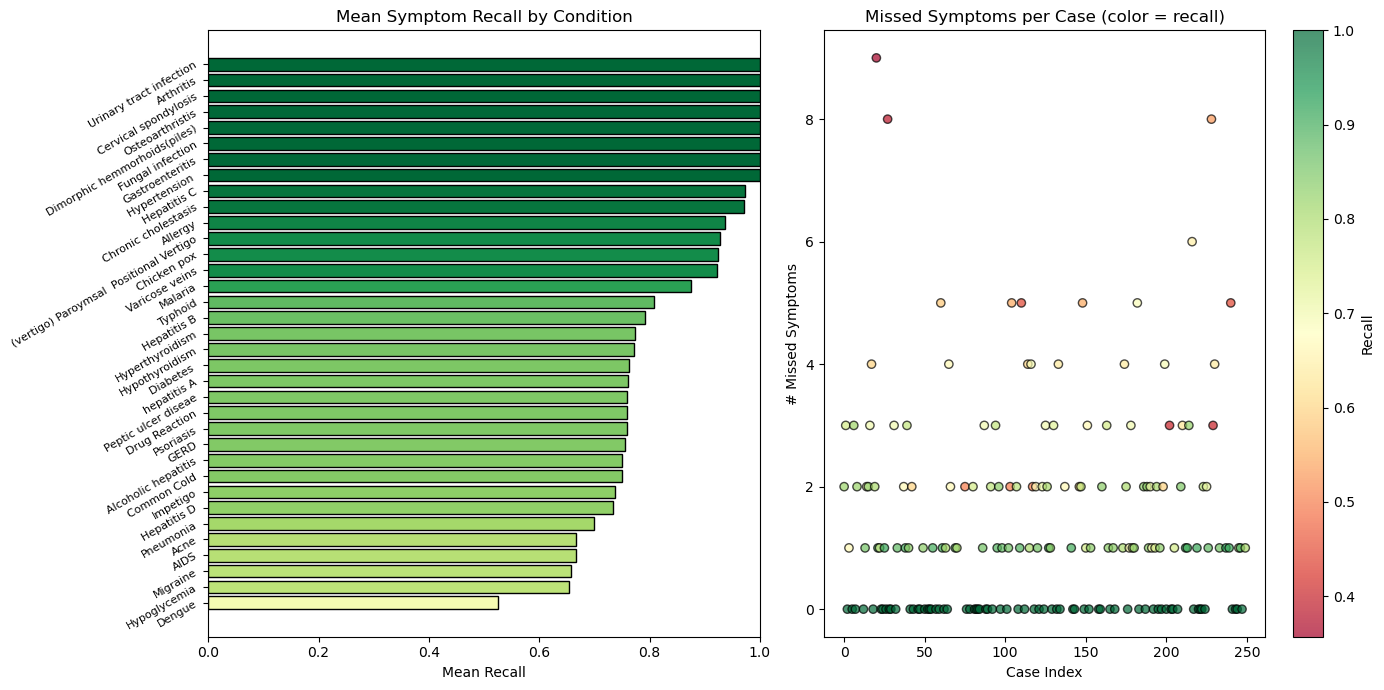

In [103]:
# 1. Recall Distribution Histogram
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# 3. Recall by Condition (boxplot style via scatter + mean)
condition_stats = analysis.groupby("true_condition")["recall"].agg(["mean", "std", "count"]).reset_index()
condition_stats = condition_stats.sort_values("mean", ascending=True)
colors = plt.cm.RdYlGn(condition_stats["mean"].values)
axes[0].barh(condition_stats["true_condition"], condition_stats["mean"], color=colors, edgecolor="black")
axes[0].set_xlabel("Mean Recall")
axes[0].set_title("Mean Symptom Recall by Condition")
axes[0].set_yticks(range(len(condition_stats)))
axes[0].set_yticklabels(condition_stats["true_condition"], fontsize=8, rotation=30)
axes[0].set_xlim(0, 1)

# 4. Number of non-detected symptoms per case
analysis["num_missed"] = analysis["non_detected_symptoms"].apply(len)
axes[1].scatter(analysis["case_index"], analysis["num_missed"], c=analysis["recall"], cmap="RdYlGn", edgecolor="black", alpha=0.7)
axes[1].set_xlabel("Case Index")
axes[1].set_ylabel("# Missed Symptoms")
axes[1].set_title("Missed Symptoms per Case (color = recall)")
cbar = plt.colorbar(axes[1].collections[0], ax=axes[1])
cbar.set_label("Recall")

plt.tight_layout()
plt.savefig("evaluation/Images/anamnesis-analysis/symptom_recall_analysis-2.png", dpi=300, bbox_inches="tight")
plt.show()

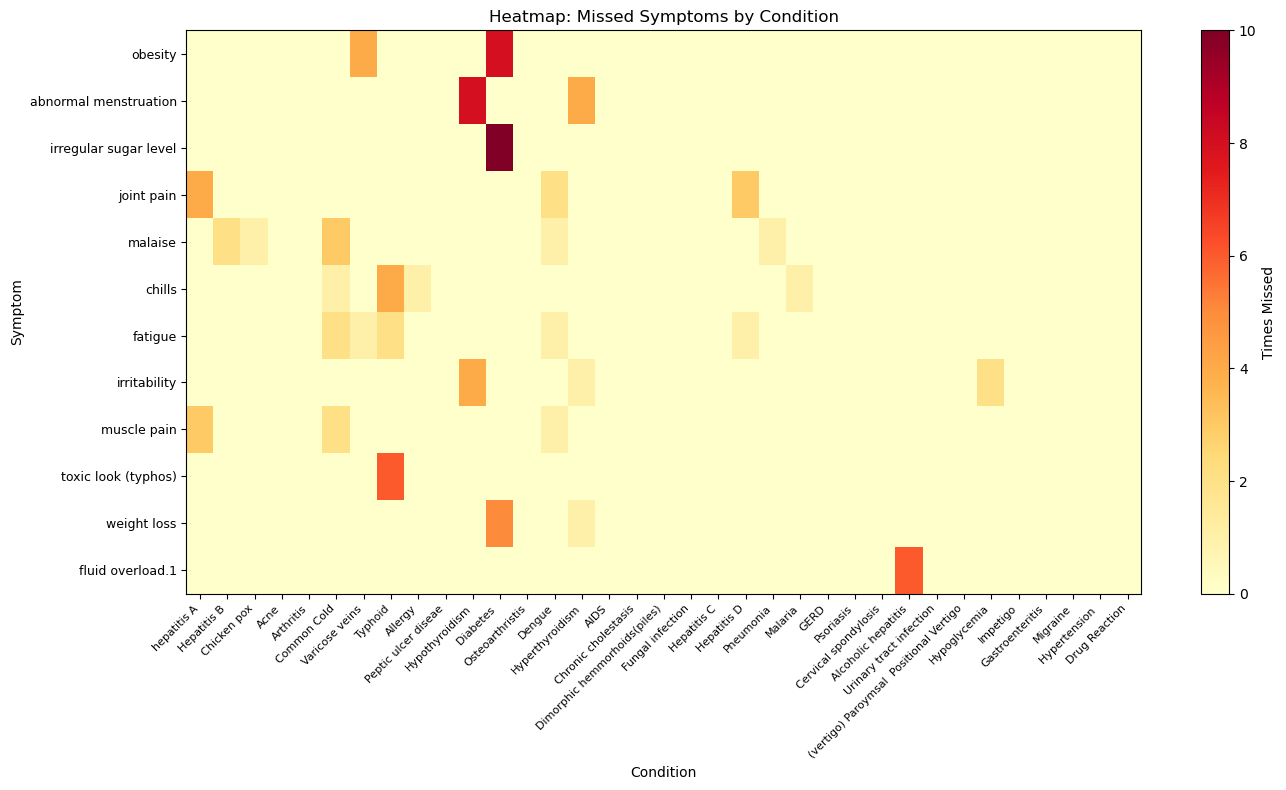

In [104]:
# 5. Heatmap: Symptom vs Condition (which symptoms are missed for which conditions)
from collections import defaultdict

symptom_condition_matrix = defaultdict(lambda: defaultdict(int))
for _, row in analysis.iterrows():
    condition = row["true_condition"]
    for symptom in row["non_detected_symptoms"]:
        symptom_condition_matrix[symptom][condition] += 1

# Convert to DataFrame and filter to top symptoms
top_symptoms = list(dict(sorted(least_detected_symptoms.items(), key=lambda x: x[1], reverse=True)[:12]).keys())
conditions = analysis["true_condition"].unique()

heatmap_data = pd.DataFrame(0, index=top_symptoms, columns=conditions)
for symptom in top_symptoms:
    for condition in conditions:
        heatmap_data.loc[symptom, condition] = symptom_condition_matrix[symptom][condition]

plt.figure(figsize=(14, 8))
plt.imshow(heatmap_data.values, cmap="YlOrRd", aspect="auto")
plt.colorbar(label="Times Missed")
plt.xticks(range(len(conditions)), conditions, rotation=45, ha="right", fontsize=8)
plt.yticks(range(len(top_symptoms)), top_symptoms, fontsize=9)
plt.xlabel("Condition")
plt.ylabel("Symptom")
plt.title("Heatmap: Missed Symptoms by Condition")
plt.tight_layout()
plt.savefig("evaluation/Images/anamnesis-analysis/symptom_condition_heatmap.png", dpi=300)
plt.show()

# Evaluation Analysis

## Main Analysis

This section evaluates the quality of the Evaluator agent's final reports using a comprehensive scoring system that considers:
- **Diagnosis accuracy** (via semantic similarity with cosine distance)
- **Report completeness** (presence of required sections)
- **Clinical quality indicators**

In [7]:
# ==========================================
# SCORING CONFIGURATION
# ==========================================

# Primary Diagnosis Scoring (MAIN FOCUS - most important)
SCORE_DIAGNOSIS_CORRECT = 90         # Correct primary diagnosis (high similarity)
SCORE_DIAGNOSIS_PARTIAL = 60          # Partially correct (medium similarity)  
SCORE_DIAGNOSIS_INCORRECT = 0         # Incorrect diagnosis (no penalty, just 0)

# Differential Diagnosis Scoring (fallback - reduced points)
SCORE_DIFF_CORRECT = 70               # Correct differential diagnosis
SCORE_DIFF_PARTIAL = 40               # Partial match in differential

# Diagnosis similarity thresholds (same for primary and differential)
DIAGNOSIS_CORRECT_THRESHOLD = 0.85    # Similarity >= 0.85 = Correct
DIAGNOSIS_PARTIAL_THRESHOLD = 0.8     # Similarity >= 0.8 = Partial match

# Section Presence Scoring (minimal - not the focus)
# All reports should have these, so they're worth very little
SCORE_HAS_DIFFERENTIAL = 1            # Has differential diagnosis section
SCORE_HAS_EXAMS = 1                   # Has recommended exams section
SCORE_HAS_TREATMENT = 1               # Has treatment plan section
SCORE_HAS_REFERENCES = 1              # Has references section

# Quality Bonuses (small bonuses for exceptional reports)
SCORE_PATIENT_SPECIFIC = 6            # Mentions patient-specific considerations
SCORE_MULTIPLE_DIFFERENTIALS = 0      # Has multiple differentials (not scoring this)


print("Scoring configuration loaded.")
print(f"\n  PRIMARY DIAGNOSIS (MAIN FOCUS):")
print(f"    Correct (sim >= {DIAGNOSIS_CORRECT_THRESHOLD}): +{SCORE_DIAGNOSIS_CORRECT} points")
print(f"    Partial (sim >= {DIAGNOSIS_PARTIAL_THRESHOLD}): +{SCORE_DIAGNOSIS_PARTIAL} points")
print(f"    Incorrect: {SCORE_DIAGNOSIS_INCORRECT} points (no penalty)")
print(f"\n  DIFFERENTIAL DIAGNOSIS (fallback):")
print(f"    Correct: +{SCORE_DIFF_CORRECT} points")
print(f"    Partial: +{SCORE_DIFF_PARTIAL} points")
print(f"\n  COMPLETENESS: Minimal (all reports should be complete)")
print(f"  NO NEGATIVE SCORES")

Scoring configuration loaded.

  PRIMARY DIAGNOSIS (MAIN FOCUS):
    Correct (sim >= 0.85): +90 points
    Partial (sim >= 0.8): +60 points
    Incorrect: 0 points (no penalty)

  DIFFERENTIAL DIAGNOSIS (fallback):
    Correct: +70 points
    Partial: +40 points

  COMPLETENESS: Minimal (all reports should be complete)
  NO NEGATIVE SCORES


In [8]:
def extract_probable_cause(report_text: str) -> str:
    """
    Extract the probable cause/diagnosis from the evaluator report.
    Looks for patterns like "Probable Cause: X" or similar section headers.
    """
    if not report_text or pd.isna(report_text):
        return None
    
    # Try to parse JSON if the report is JSON-encoded
    try:
        report_text = json.loads(report_text)
    except:
        pass
    
    if not isinstance(report_text, str):
        report_text = str(report_text)
    
    # Common patterns for diagnosis extraction
    patterns = [
        r'\*\*Probable Cause:\s*([^\*\n]+)',                    # **Probable Cause: X**
        r'Probable Cause:\s*\*\*([^\*]+)\*\*',                  # Probable Cause: **X**
        r'Probable Cause:\s*([^\n\*]+)',                        # Probable Cause: X
        r'Probable Diagnosis:\s*([^\n\*]+)',                        # Probable Cause: X
        r'Primary Diagnosis:\s*\*\*([^\*]+)\*\*',               # Primary Diagnosis: **X**
        r'Primary Diagnosis:\s*([^\n\*]+)',                     # Primary Diagnosis: X
        r'\*\*Diagnosis:\s*([^\*\n]+)',                         # **Diagnosis: X**
        r'Most Likely Diagnosis:\s*\*\*([^\*]+)\*\*',           # Most Likely Diagnosis: **X**
    ]
    
    for pattern in patterns:
        match = re.search(pattern, report_text, re.IGNORECASE)
        if match:
            diagnosis = match.group(1).strip()
            # Clean up common artifacts
            diagnosis = re.sub(r'\*+', '', diagnosis)
            diagnosis = re.sub(r'\s+', ' ', diagnosis)
            return diagnosis.strip()
    
    return None


def extract_differential_diagnoses(report_text: str) -> list:
    """
    Extract differential diagnoses from the evaluator report.
    These are secondary hypotheses listed in the "Considered Differential Diagnoses" section.
    
    Format in reports:
    **Considered Differential Diagnoses:**
    *   **Condition Name (Likelihood: Level):** Description...
    
    Returns a list of differential diagnosis strings.
    """
    if not report_text or pd.isna(report_text):
        return []
    
    # Try to parse JSON if the report is JSON-encoded
    try:
        report_text = json.loads(report_text)
    except:
        pass
    
    if not isinstance(report_text, str):
        report_text = str(report_text)
    
    differentials = []
    
    # Look for the "Considered Differential Diagnoses:" section
    # Pattern: **Condition Name (Likelihood: X):** or * **Condition Name:**
    section_start_patterns = [
        r'\*\*Considered Differential Diagnos(?:es|is):\*\*\s*\n(.*?)(?=\n\s*(?:###|\*\*\d|$))',
        r'Considered Differential Diagnos(?:es|is):\s*\n(.*?)(?=\n\s*(?:###|\*\*\d|$))',
        r'\*\*Differential Diagnoses:\*\*\s*\n(.*?)(?=\n\s*(?:###|\*\*\d|$))',
    ]
    
    section_text = None
    for pattern in section_start_patterns:
        match = re.search(pattern, report_text, re.IGNORECASE | re.DOTALL)
        if match:
            section_text = match.group(1)
            break
    
    # Format: **Differential Diagnoses:** Condition1, Condition2, Condition3...
    if not section_text:
        inline_diff_patterns = [
            r'\*\*Differential Diagnos(?:es|is):\*\*\s*([^\n]+)',
            r'Differential Diagnos(?:es|is):\s*([^\n]+)',
        ]
        for pattern in inline_diff_patterns:
            match = re.search(pattern, report_text, re.IGNORECASE)
            if match:
                inline_text = match.group(1).strip()
                # Split by comma and clean up
                candidates = re.split(r',\s*', inline_text)
                for diag in candidates:
                    diag = diag.strip()
                    # Remove trailing periods, asterisks, etc.
                    diag = re.sub(r'[\*\.]+$', '', diag).strip()
                    # Filter valid diagnoses
                    if len(diag) > 3 and len(diag) < 150:
                        # Skip likelihood labels and common non-diagnosis words
                        if not re.match(r'^(High|Medium|Low|Ranked|and|or|the)$', diag, re.IGNORECASE):
                            differentials.append(diag)
                if differentials:
                    return differentials[:5]  # Return early if we found inline differentials
    
    if section_text:
        # Extract diagnoses from bullet points
        # Format: *   **Condition Name (Likelihood: Level):** or *   **Condition Name:**
        diff_patterns = [
            r'\*\s+\*\*([^*\(]+?)\s*\(Likelihood:',      # *   **Condition (Likelihood:
            r'\*\s+\*\*([^*:]+?):\*\*',                   # *   **Condition:**
            r'-\s+\*\*([^*\(]+?)\s*\(Likelihood:',        # -   **Condition (Likelihood:
            r'-\s+\*\*([^*:]+?):\*\*',                    # -   **Condition:**
            
        ]
        
        for pattern in diff_patterns:
            matches = re.findall(pattern, section_text)
            for diag in matches:
                diag = diag.strip()
                diag = re.sub(r'\*+', '', diag)
                diag = re.sub(r'\s+', ' ', diag)
                # Filter valid diagnoses
                if len(diag) > 3 and len(diag) < 150 and diag not in differentials:
                    # Skip if it's just a likelihood label
                    if not re.match(r'^(High|Medium|Low|Ranked)', diag, re.IGNORECASE):
                        differentials.append(diag.strip())
    
    # Fallback: Look for inline mentions like "alternative" or "also considered"
    if not differentials:
        inline_patterns = [
            r'also considered[:\s]+\*\*([^*]+)\*\*',
            r'alternative diagnosis[:\s]+\*\*([^*]+)\*\*',
        ]
        for pattern in inline_patterns:
            matches = re.findall(pattern, report_text, re.IGNORECASE)
            for diag in matches:
                diag = diag.strip()
                if len(diag) > 3 and len(diag) < 150:
                    differentials.append(diag)
    
    return differentials[:5]  # Limit to top 5 differentials


def calculate_diagnosis_similarity(extracted_diagnosis: str, true_condition: str, index) -> float:
    """
    Calculate cosine similarity between extracted diagnosis and true condition
    using Gemini embeddings.
    """
    if not extracted_diagnosis or not true_condition:
        return 0.0
    
    try:
        # Get embeddings for both
        embeddings = embeddings_model.embed_documents([extracted_diagnosis, true_condition])
        
        if len(embeddings) < 2:
            return 0.0
        
        diag_emb = np.asarray(embeddings[0], dtype=float)
        true_emb = np.asarray(embeddings[1], dtype=float)
        
        # Calculate cosine similarity
        diag_norm = np.linalg.norm(diag_emb)
        true_norm = np.linalg.norm(true_emb)
        
        if diag_norm == 0 or true_norm == 0:
            return 0.0
        
        similarity = np.dot(diag_emb, true_emb) / (diag_norm * true_norm)
        return float(similarity)
    
    except Exception as e:
        print(f"Error calculating similarity for index {index}: {e}")
        return 0.0


def check_section_presence(report_text: str) -> dict:
    """
    Check for the presence of key sections in the report.
    Returns a dictionary with boolean flags for each section.
    """
    if not report_text or pd.isna(report_text):
        return {
            'has_differential': False,
            'has_exams': False,
            'has_treatment': False,
            'has_references': False,
            'has_patient_specific': False,
            'multiple_differentials': False
        }
    
    try:
        report_text = json.loads(report_text)
    except:
        pass
    
    if not isinstance(report_text, str):
        report_text = str(report_text)
    
    report_lower = report_text.lower()
    
    # Check for differential diagnosis section
    has_differential = any(term in report_lower for term in [
        'differential diagnos', 'considered differential', 'alternative diagnos'
    ])
    
    # Check for recommended exams section
    has_exams = any(term in report_lower for term in [
        'recommended exam', 'further investigation', 'diagnostic test', 
        'laboratory test', 'imaging stud'
    ])
    
    # Check for treatment section
    has_treatment = any(term in report_lower for term in [
        'treatment plan', 'management plan', 'therapeutic strategy',
        'recommended management'
    ])
    
    # Check for references
    has_references = any(term in report_lower for term in [
        'references', 'pubmed', 'medlineplus', 'mayo clinic'
    ])
    
    # Check for patient-specific considerations
    has_patient_specific = 'patient-specific' in report_lower or 'patient specific' in report_lower
    
    # Check for multiple differentials (at least 2 mentioned)
    diff_count = report_lower.count('considered differential') + \
                 report_lower.count('alternative diagnos') + \
                 report_lower.count('ranked low') + \
                 report_lower.count('likelihood:')
    multiple_differentials = diff_count >= 2
    
    return {
        'has_differential': has_differential,
        'has_exams': has_exams,
        'has_treatment': has_treatment,
        'has_references': has_references,
        'has_patient_specific': has_patient_specific,
        'multiple_differentials': multiple_differentials
    }

In [9]:
def score_evaluator_report(row) -> dict:
    """
    Calculate comprehensive score for an evaluator report.
    
    Scoring Logic (focused on DIAGNOSIS ACCURACY):
    1. First check primary diagnosis (Probable Cause) - full points
    2. If primary diagnosis is incorrect, check differential diagnoses - reduced points
    3. Minimal completeness scoring (all reports should be complete)
    4. NO negative scores/penalties
    
    Returns a dictionary with:
    - total_score: Overall score
    - diagnosis_score: Points from diagnosis accuracy
    - completeness_score: Points from section presence (minimal)
    - quality_score: Points from quality indicators
    - extracted_diagnosis: The diagnosis extracted from the report
    - diagnosis_similarity: Cosine similarity with true condition
    - diagnosis_category: CORRECT, PARTIAL, DIFF_CORRECT, DIFF_PARTIAL, INCORRECT, MISSING, EMERGENCY
    - matched_differential: Which differential matched (if applicable)
    - breakdown: Detailed breakdown of all scoring components
    """
    final_report = row.get('final_report', '')
    true_condition = row.get('true_condition', '')
    
    # Skip emergency-aborted reports
    if 'EMERGENCY DETECTED' in str(row.get('anamnesis_report', '')):
        return {
            'total_score': None,
            'diagnosis_score': None,
            'completeness_score': None,
            'quality_score': None,
            'extracted_diagnosis': None,
            'diagnosis_similarity': None,
            'diagnosis_category': 'EMERGENCY',
            'matched_differential': None,
            'differentials_found': [],
            'breakdown': {'skipped': 'Emergency case'}
        }
    
    # Initialize scores and breakdown
    total_score = 0
    diagnosis_score = 0
    completeness_score = 0
    quality_score = 0
    breakdown = {}
    matched_differential = None
    differentials_found = []
    
    # =========================================
    # 1. PRIMARY DIAGNOSIS SCORING (MAIN FOCUS)
    # =========================================
    extracted_diagnosis = extract_probable_cause(final_report)
    diagnosis_similarity = 0.0
    diagnosis_category = 'MISSING'
    
    primary_matched = False
    
    if extracted_diagnosis:
        diagnosis_similarity = calculate_diagnosis_similarity(extracted_diagnosis, true_condition, row.name)
        
        if diagnosis_similarity >= DIAGNOSIS_CORRECT_THRESHOLD:
            diagnosis_score = SCORE_DIAGNOSIS_CORRECT
            diagnosis_category = 'CORRECT'
            primary_matched = True
            breakdown['diagnosis'] = f'+{SCORE_DIAGNOSIS_CORRECT} (PRIMARY correct, sim={diagnosis_similarity:.3f})'
        elif diagnosis_similarity >= DIAGNOSIS_PARTIAL_THRESHOLD:
            diagnosis_score = SCORE_DIAGNOSIS_PARTIAL
            diagnosis_category = 'PARTIAL'
            primary_matched = True
            breakdown['diagnosis'] = f'+{SCORE_DIAGNOSIS_PARTIAL} (PRIMARY partial, sim={diagnosis_similarity:.3f})'
    
    # =========================================
    # 2. DIFFERENTIAL DIAGNOSIS FALLBACK
    # =========================================
    # Only check differentials if primary diagnosis didn't match
    if not primary_matched:
        differentials_found = extract_differential_diagnoses(final_report)
        
        if differentials_found:
            best_diff_similarity = 0.0
            best_diff_diagnosis = None
            
            # Check each differential diagnosis
            for diff in differentials_found:
                diff_sim = calculate_diagnosis_similarity(diff, true_condition, row.name)
                if diff_sim > best_diff_similarity:
                    best_diff_similarity = diff_sim
                    best_diff_diagnosis = diff
            
            # Score based on best matching differential
            if best_diff_similarity >= DIAGNOSIS_CORRECT_THRESHOLD:
                diagnosis_score = SCORE_DIFF_CORRECT
                diagnosis_category = 'DIFF_CORRECT'
                matched_differential = best_diff_diagnosis
                breakdown['diagnosis'] = f'+{SCORE_DIFF_CORRECT} (DIFFERENTIAL correct: "{best_diff_diagnosis}", sim={best_diff_similarity:.3f})'
                breakdown['primary_missed'] = f'Primary "{extracted_diagnosis}" sim={diagnosis_similarity:.3f}'
            elif best_diff_similarity >= DIAGNOSIS_PARTIAL_THRESHOLD:
                diagnosis_score = SCORE_DIFF_PARTIAL
                diagnosis_category = 'DIFF_PARTIAL'
                matched_differential = best_diff_diagnosis
                breakdown['diagnosis'] = f'+{SCORE_DIFF_PARTIAL} (DIFFERENTIAL partial: "{best_diff_diagnosis}", sim={best_diff_similarity:.3f})'
                breakdown['primary_missed'] = f'Primary "{extracted_diagnosis}" sim={diagnosis_similarity:.3f}'
            else:
                # Neither primary nor differentials matched - 0 points (no penalty)
                if extracted_diagnosis:
                    diagnosis_score = SCORE_DIAGNOSIS_INCORRECT
                    diagnosis_category = 'INCORRECT'
                    breakdown['diagnosis'] = f'{SCORE_DIAGNOSIS_INCORRECT} (incorrect, primary sim={diagnosis_similarity:.3f})'
                    breakdown['differentials_checked'] = f'Checked {len(differentials_found)} differentials, best sim={best_diff_similarity:.3f}'
                else:
                    diagnosis_score = 0  # No penalty, just 0
                    diagnosis_category = 'MISSING'
                    breakdown['diagnosis'] = '0 (no diagnosis found)'
        else:
            # No differentials found to check - 0 points (no penalty)
            if extracted_diagnosis:
                diagnosis_score = SCORE_DIAGNOSIS_INCORRECT
                diagnosis_category = 'INCORRECT'
                breakdown['diagnosis'] = f'{SCORE_DIAGNOSIS_INCORRECT} (incorrect, sim={diagnosis_similarity:.3f}, no differentials found)'
            else:
                diagnosis_score = 0  # No penalty, just 0
                diagnosis_category = 'MISSING'
                breakdown['diagnosis'] = '0 (no diagnosis found)'
    
    # =========================================
    # 3. COMPLETENESS SCORING (Minimal - not the focus)
    # =========================================
    sections = check_section_presence(final_report)
    
    # Section presence adds minimal points (all reports should have these)
    if sections['has_differential']:
        completeness_score += SCORE_HAS_DIFFERENTIAL
        if SCORE_HAS_DIFFERENTIAL > 0:
            breakdown['differential'] = f'+{SCORE_HAS_DIFFERENTIAL}'
    
    if sections['has_exams']:
        completeness_score += SCORE_HAS_EXAMS
        if SCORE_HAS_EXAMS > 0:
            breakdown['exams'] = f'+{SCORE_HAS_EXAMS}'
    
    if sections['has_treatment']:
        completeness_score += SCORE_HAS_TREATMENT
        if SCORE_HAS_TREATMENT > 0:
            breakdown['treatment'] = f'+{SCORE_HAS_TREATMENT}'
    # No penalty for missing treatment
    
    if sections['has_references']:
        completeness_score += SCORE_HAS_REFERENCES
        if SCORE_HAS_REFERENCES > 0:
            breakdown['references'] = f'+{SCORE_HAS_REFERENCES}'
    
    # =========================================
    # 4. QUALITY SCORING (Small bonuses only)
    # =========================================
    if sections['multiple_differentials']:
        quality_score += SCORE_MULTIPLE_DIFFERENTIALS
        if SCORE_MULTIPLE_DIFFERENTIALS > 0:
            breakdown['multiple_diff'] = f'+{SCORE_MULTIPLE_DIFFERENTIALS}'
    
    if sections['has_patient_specific']:
        quality_score += SCORE_PATIENT_SPECIFIC
        if SCORE_PATIENT_SPECIFIC > 0:
            breakdown['patient_specific'] = f'+{SCORE_PATIENT_SPECIFIC}'
    
    # No length penalty - removed
    
    # Calculate total
    total_score = diagnosis_score + completeness_score + quality_score
    
    return {
        'total_score': total_score,
        'diagnosis_score': diagnosis_score,
        'completeness_score': completeness_score,
        'quality_score': quality_score,
        'extracted_diagnosis': extracted_diagnosis,
        'diagnosis_similarity': diagnosis_similarity,
        'diagnosis_category': diagnosis_category,
        'matched_differential': matched_differential,
        'differentials_found': differentials_found,
        'breakdown': breakdown
    }


In [10]:
# Run the evaluation on all reports
print("EVALUATING REPORTS (Don't run if you have the score CSV files)...")

# Score all reports
# Run evaluation for blackwell reports
evaluation_results = []
if not os.path.exists("evaluation/scores/evaluator_report_scores.csv"):
    print("  Scoring Blackwell evaluator reports...")
    for i in range(len(reports)):
        if i % 50 == 0:
            print(f"Processing (Blackwell) report {i+1}/{len(reports)}...")
        
        result = score_evaluator_report(reports.iloc[i])
        result['case_index'] = i
        result['true_condition'] = reports.iloc[i]['true_condition']
        evaluation_results.append(result)
        
        # Rate limiting for embedding API
        if result['diagnosis_similarity'] is not None:
            time.sleep(0.2)

    eval_df = pd.DataFrame(evaluation_results)
    # Filter out emergency cases for main analysis
    eval_df_scored = eval_df[eval_df['diagnosis_category'] != 'EMERGENCY'].copy()
    eval_df_scored.to_csv("evaluation/scores/evaluator_report_scores.csv", index=False)
else:
    print("  Loading existing Blackwell evaluator report scores...")
    eval_df_scored = pd.read_csv("evaluation/scores/evaluator_report_scores.csv")

# Run evaluation for raw reports
evaluation_results = []
if not os.path.exists("evaluation/scores/gemini_raw_report_scores.csv"):
    print("  Scoring Gemini Raw reports...")
    for i in range(len(raw_eval)):
        if i % 50 == 0:
            print(f"Processing (Gemini Raw) report {i+1}/{len(raw_eval)}...")
        
        result = score_evaluator_report(raw_eval.iloc[i])
    result['case_index'] = i
    result['true_condition'] = raw_eval.iloc[i]['true_condition']
    evaluation_results.append(result)
    
    # Rate limiting for embedding API
    if result['diagnosis_similarity'] is not None:
        time.sleep(0.2)

    raw_eval_df = pd.DataFrame(evaluation_results)
    # Filter out emergency cases for main analysis
    raw_scored = raw_eval_df[raw_eval_df['diagnosis_category'] != 'EMERGENCY'].copy()
    raw_scored.to_csv("evaluation/scores/gemini_raw_report_scores.csv", index=False)
else:
    print("  Loading existing Gemini Raw report scores...")
    raw_scored = pd.read_csv("evaluation/scores/gemini_raw_report_scores.csv")

# Run evaluation for Gemini (W/A) reports
evaluation_results = []
if not os.path.exists("evaluation/scores/gemini_wa_report_scores.csv"):
    print("  Scoring Gemini W/A reports...")
    for i in range(len(gai_eval)):
        if i % 50 == 0:
            print(f"Processing (Gemini W/A) report {i+1}/{len(gai_eval)}...")
        
        result = score_evaluator_report(gai_eval.iloc[i])
    result['case_index'] = i
    result['true_condition'] = gai_eval.iloc[i]['true_condition']
    evaluation_results.append(result)
    
    # Rate limiting for embedding API
    if result['diagnosis_similarity'] is not None:
        time.sleep(0.2)

    gai_eval_df = pd.DataFrame(evaluation_results)
    # Filter out emergency cases for main analysis
    gai_scored = gai_eval_df[gai_eval_df['diagnosis_category'] != 'EMERGENCY'].copy()
    gai_scored.to_csv("evaluation/scores/gemini_wa_report_scores.csv", index=False)
else:
    print("  Loading existing Gemini W/A report scores...")
    gai_scored = pd.read_csv("evaluation/scores/gemini_wa_report_scores.csv")
    
print(f"\nEvaluation complete!")
print(f"  Total reports: {len(reports)}")
print(f"  Scored reports: {len(eval_df_scored)}")
print(f"  Emergency cases (skipped): {len(eval_df) - len(eval_df_scored)}")

# Show score summary
print(f"\nScore Summary:")
print(f"  Mean Total Score:  {eval_df_scored['total_score'].mean():.1f}")
print(f"  Mean Diagnosis:    {eval_df_scored['diagnosis_score'].mean():.1f}")
print(f"  Mean Completeness: {eval_df_scored['completeness_score'].mean():.1f}")
print(f"  Mean Quality:      {eval_df_scored['quality_score'].mean():.1f}")

EVALUATING REPORTS (Don't run if you have the score CSV files)...
  Loading existing Blackwell evaluator report scores...
  Loading existing Gemini Raw report scores...
  Loading existing Gemini W/A report scores...

Evaluation complete!
  Total reports: 250
  Scored reports: 181


NameError: name 'eval_df' is not defined

In [ ]:
eval_df_scored = pd.read_csv("evaluation/scores/evaluator_report_scores.csv")
gai_scored = pd.read_csv("evaluation/scores/gemini_wa_report_scores.csv")
raw_scored = pd.read_csv("evaluation/scores/gemini_raw_report_scores.csv")

In [ ]:
# Display summary statistics
print("EVALUATION SUMMARY (DIAGNOSIS-FOCUSED SCORING)")
print("=" * 60)

# Score statistics
print("\nSCORE STATISTICS:")
print(f"  Mean Total Score:  {eval_df_scored['total_score'].mean():.1f}")
print(f"  Median Total Score: {eval_df_scored['total_score'].median():.1f}")
print(f"  Std Deviation:     {eval_df_scored['total_score'].std():.1f}")
print(f"  Min Score:         {eval_df_scored['total_score'].min():.1f}")
print(f"  Max Score:         {eval_df_scored['total_score'].max():.1f}")

# Maximum possible score
max_possible = SCORE_DIAGNOSIS_CORRECT + SCORE_PATIENT_SPECIFIC + 4
print(f"\n  Max Possible Score: {max_possible}")
print(f"  Score Range: 0 to {max_possible} (no negative scores)")

# Diagnosis accuracy breakdown - now includes differential categories
print("\nDIAGNOSIS ACCURACY (Main Focus):")
diag_counts = eval_df_scored['diagnosis_category'].value_counts()
for cat in ['CORRECT', 'PARTIAL', 'DIFF_CORRECT', 'DIFF_PARTIAL', 'INCORRECT', 'MISSING']:
    count = diag_counts.get(cat, 0)
    pct = count / len(eval_df_scored) * 100
    cat_label = cat
    if cat.startswith('DIFF_'):
        cat_label = f"  ↳ {cat}"  # Indent differential categories
    print(f"  {cat_label}: {count} ({pct:.1f}%)")

# Aggregate correct/incorrect
primary_correct = diag_counts.get('CORRECT', 0) + diag_counts.get('PARTIAL', 0)
diff_correct = diag_counts.get('DIFF_CORRECT', 0) + diag_counts.get('DIFF_PARTIAL', 0)
total_correct = primary_correct + diff_correct
incorrect = diag_counts.get('INCORRECT', 0) + diag_counts.get('MISSING', 0)

print(f"\n  SUMMARY:")
print(f"    Primary matches (CORRECT+PARTIAL): {primary_correct} ({primary_correct/len(eval_df_scored)*100:.1f}%)")
print(f"    Differential matches: {diff_correct} ({diff_correct/len(eval_df_scored)*100:.1f}%)")
print(f"    Total correct (any match): {total_correct} ({total_correct/len(eval_df_scored)*100:.1f}%)")
print(f"    Incorrect/Missing: {incorrect} ({incorrect/len(eval_df_scored)*100:.1f}%)")

# Similarity statistics
print("\nDIAGNOSIS SIMILARITY:")
valid_sim = eval_df_scored[eval_df_scored['diagnosis_similarity'] > 0]['diagnosis_similarity']
print(f"  Mean Similarity:   {valid_sim.mean():.3f}")
print(f"  Median Similarity: {valid_sim.median():.3f}")
print(f"  Min Similarity:    {valid_sim.min():.3f}")
print(f"  Max Similarity:    {valid_sim.max():.3f}")

# Component score breakdown
print("\nCOMPONENT SCORES (Mean):")
print(f"  Diagnosis Score:    {eval_df_scored['diagnosis_score'].mean():.1f} (main focus)")
print(f"  Completeness Score: {eval_df_scored['completeness_score'].mean():.1f} (minimal)")
print(f"  Quality Score:      {eval_df_scored['quality_score'].mean():.1f} (small bonuses)")

EVALUATION SUMMARY (DIAGNOSIS-FOCUSED SCORING)

SCORE STATISTICS:
  Mean Total Score:  83.4
  Median Total Score: 100.0
  Std Deviation:     28.6
  Min Score:         4.0
  Max Score:         100.0

  Max Possible Score: 100
  Score Range: 0 to 100 (no negative scores)

DIAGNOSIS ACCURACY (Main Focus):
  CORRECT: 123 (68.0%)
  PARTIAL: 27 (14.9%)
    ↳ DIFF_CORRECT: 3 (1.7%)
    ↳ DIFF_PARTIAL: 10 (5.5%)
  INCORRECT: 18 (9.9%)
  MISSING: 0 (0.0%)

  SUMMARY:
    Primary matches (CORRECT+PARTIAL): 150 (82.9%)
    Differential matches: 13 (7.2%)
    Total correct (any match): 163 (90.1%)
    Incorrect/Missing: 18 (9.9%)

DIAGNOSIS SIMILARITY:
  Mean Similarity:   0.885
  Median Similarity: 0.895
  Min Similarity:    0.680
  Max Similarity:    1.000

COMPONENT SCORES (Mean):
  Diagnosis Score:    73.5 (main focus)
  Completeness Score: 4.0 (minimal)
  Quality Score:      5.9 (small bonuses)


In [ ]:
# Detailed case-by-case view
print("=" * 60)
print("CASE-BY-CASE DIAGNOSIS COMPARISON")
print("=" * 60)

for idx, row in eval_df_scored.iterrows():
    cat_emoji = {
        'CORRECT': '✓', 
        'PARTIAL': '~', 
        'DIFF_CORRECT': '◐',  # Differential correct
        'DIFF_PARTIAL': '◔',  # Differential partial
        'INCORRECT': '✗', 
        'MISSING': '?'
    }
    emoji = cat_emoji.get(row['diagnosis_category'], '?')
    
    print(f"\nCase {row['case_index']:3d} [{emoji}] {row['diagnosis_category']}")
    print(f"  True Condition:      {row['true_condition']}")
    print(f"  Extracted Diagnosis: {row['extracted_diagnosis']}")
    print(f"  Primary Similarity:  {row['diagnosis_similarity']:.3f}")
    
    # Show differential match if applicable
    if row['diagnosis_category'].startswith('DIFF_'):
        print(f"  Matched Differential: {row['matched_differential']}")
        if row.get('differentials_found'):
            print(f"  Differentials Found:  {row['differentials_found']}")
    
    print(f"  Total Score:         {row['total_score']}")

CASE-BY-CASE DIAGNOSIS COMPARISON

Case   0 [✓] CORRECT
  True Condition:      hepatitis A
  Extracted Diagnosis: Acute Viral Hepatitis
  Primary Similarity:  0.895
  Total Score:         100.0

Case   1 [◔] DIFF_PARTIAL
  True Condition:      Hepatitis B
  Extracted Diagnosis: Cholestasis with Obstructive Jaundice
  Primary Similarity:  0.786
  Matched Differential: Acute Viral Hepatitis / Autoimmune Hepatitis / Drug-induced Liver Injury
  Differentials Found:  ['Biliary Obstruction', 'Acute Viral Hepatitis / Autoimmune Hepatitis / Drug-induced Liver Injury']
  Total Score:         50.0

Case   2 [✓] CORRECT
  True Condition:      Chicken pox
  Extracted Diagnosis: Chickenpox (Varicella)
  Primary Similarity:  0.973
  Total Score:         100.0

Case   3 [✓] CORRECT
  True Condition:      Acne
  Extracted Diagnosis: Adult Female Acne (Acne Vulgaris), recurrent type
  Primary Similarity:  0.884
  Total Score:         100.0

Case   5 [✓] CORRECT
  True Condition:      Arthritis
  Extrac

### Evaluator Score Visualizations

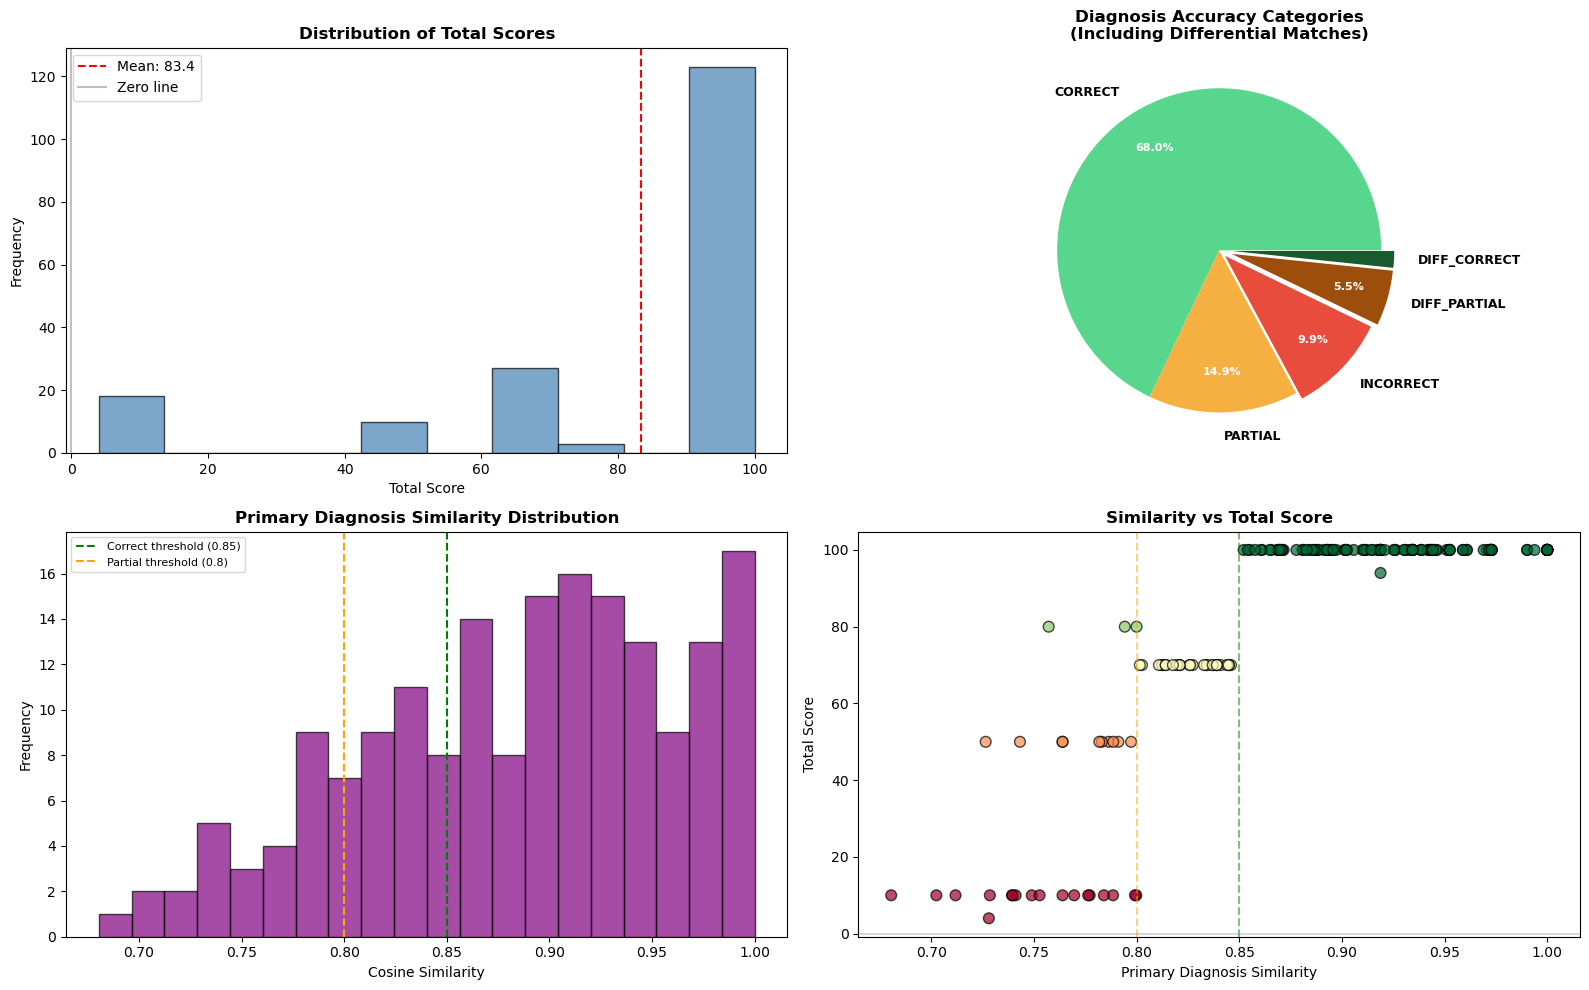

In [ ]:
# Comprehensive Evaluator Score Visualizations
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# 1. Total Score Distribution
axes[0, 0].hist(eval_df_scored['total_score'], bins=10, color='steelblue', edgecolor='black', alpha=0.7)
axes[0, 0].axvline(eval_df_scored['total_score'].mean(), color='red', linestyle='--', 
                    label=f"Mean: {eval_df_scored['total_score'].mean():.1f}")
axes[0, 0].axvline(0, color='gray', linestyle='-', alpha=0.5, label='Zero line')
axes[0, 0].set_xlabel('Total Score')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of Total Scores', fontweight='bold')
axes[0, 0].legend()

# 2. Diagnosis Category Pie Chart (now includes differential categories)
cat_counts = eval_df_scored['diagnosis_category'].value_counts()
colors_map = {
    'CORRECT': '#58d68d',       # Light green (primary)
    'PARTIAL': '#f5b041',       # Light orange (primary)
    'DIFF_CORRECT': '#1a5a2e',  # Dark green (differential)
    'DIFF_PARTIAL': '#9c4e0a',  # Dark orange/brown (differential)
    'INCORRECT': '#e74c3c',     # Red
    'MISSING': '#95a5a6'        # Gray
}
colors = [colors_map.get(cat, '#3498db') for cat in cat_counts.index]
explode = [0.05 if cat in ['INCORRECT', 'MISSING'] else 0.08 if 'DIFF' in cat else 0 for cat in cat_counts.index]
wedges, texts, autotexts = axes[0, 1].pie(
    cat_counts.values, 
    labels=cat_counts.index, 
    colors=colors,
    explode=explode,
    autopct=lambda p: f'{p:.1f}%' if p >= 2 else '',
    startangle=0,
    pctdistance=0.75,
    labeldistance=1.15
)
# Style the labels and percentages for better readability
for text in texts:
    text.set_fontsize(9)
    text.set_fontweight('bold')
for autotext in autotexts:
    autotext.set_fontsize(8)
    autotext.set_fontweight('bold')
    autotext.set_color('white')
axes[0, 1].set_title('Diagnosis Accuracy Categories\n(Including Differential Matches)', fontweight='bold')

# 3. Diagnosis Similarity Distribution
valid_sim = eval_df_scored[eval_df_scored['diagnosis_similarity'] > 0]['diagnosis_similarity']
axes[1, 0].hist(valid_sim, bins=20, color='purple', edgecolor='black', alpha=0.7)
axes[1, 0].axvline(DIAGNOSIS_CORRECT_THRESHOLD, color='green', linestyle='--', 
                    label=f'Correct threshold ({DIAGNOSIS_CORRECT_THRESHOLD})')
axes[1, 0].axvline(DIAGNOSIS_PARTIAL_THRESHOLD, color='orange', linestyle='--',
                    label=f'Partial threshold ({DIAGNOSIS_PARTIAL_THRESHOLD})')
axes[1, 0].set_xlabel('Cosine Similarity')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title('Primary Diagnosis Similarity Distribution', fontweight='bold')
axes[1, 0].legend(fontsize=8)



# 6. Similarity vs Total Score Scatter (with differential categories)
category_map = {
    'CORRECT': 0, 
    'PARTIAL': 1, 
    'DIFF_CORRECT': 0.5,  # Between correct and partial
    'DIFF_PARTIAL': 1.5,  # Between partial and incorrect
    'INCORRECT': 2, 
    'MISSING': 3
}
scatter = axes[1, 1].scatter(
    eval_df_scored['diagnosis_similarity'], 
    eval_df_scored['total_score'],
    c=eval_df_scored['diagnosis_category'].map(category_map),
    cmap='RdYlGn_r',
    edgecolor='black',
    alpha=0.7,
    s=60
)
axes[1, 1].axvline(DIAGNOSIS_CORRECT_THRESHOLD, color='green', linestyle='--', alpha=0.5)
axes[1, 1].axvline(DIAGNOSIS_PARTIAL_THRESHOLD, color='orange', linestyle='--', alpha=0.5)
axes[1, 1].axhline(0, color='gray', linestyle='-', alpha=0.3)
axes[1, 1].set_xlabel('Primary Diagnosis Similarity')
axes[1, 1].set_ylabel('Total Score')
axes[1, 1].set_title('Similarity vs Total Score', fontweight='bold')

plt.tight_layout()
plt.savefig('evaluation/Images/evaluator-analysis/scoring_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

C:\Users\lukas\AppData\Local\Temp\ipykernel_20904\596937214.py:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_yticklabels(bottom_conditions.index, fontsize=10, rotation=30)


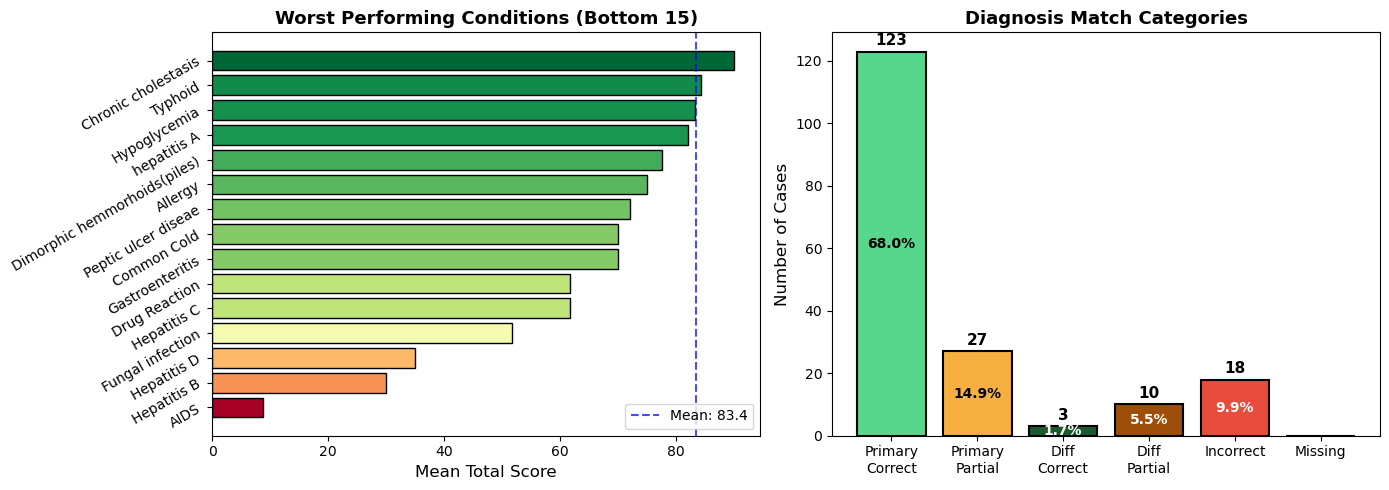

In [ ]:
# Differential Diagnosis Analysis Visualizations
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# 2. Diagnosis Category Bar Chart (including differential categories)
categories = ['Primary\nCorrect', 'Primary\nPartial', 'Diff\nCorrect', 'Diff\nPartial', 'Incorrect', 'Missing']
counts = [
    diag_counts.get('CORRECT', 0),
    diag_counts.get('PARTIAL', 0),
    diag_counts.get('DIFF_CORRECT', 0),
    diag_counts.get('DIFF_PARTIAL', 0),
    diag_counts.get('INCORRECT', 0),
    diag_counts.get('MISSING', 0)
]
colors = ['#58d68d', '#f5b041', '#1a5a2e', '#9c4e0a', '#e74c3c', '#95a5a6']

bars = axes[1].bar(categories, counts, color=colors, edgecolor='black', linewidth=1.5)
axes[1].set_ylabel('Number of Cases', fontsize=12)
axes[1].set_title('Diagnosis Match Categories', fontweight='bold', fontsize=13)

# Add value labels on bars
for bar, count in zip(bars, counts):
    if count > 0:
        axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1, 
                        f'{count}', ha='center', va='bottom', fontweight='bold', fontsize=11)

# Add percentage annotations (use black text for light bars, white for dark)
total = sum(counts)
dark_bars = [2, 3, 4]  # DIFF_CORRECT, DIFF_PARTIAL, INCORRECT indices
for i, (bar, count) in enumerate(zip(bars, counts)):
    if count > 0:
        pct = count / total * 100
        text_color = 'white' if i in dark_bars else 'black'
        axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height()/2, 
                        f'{pct:.1f}%', ha='center', va='center', color=text_color, fontweight='bold', fontsize=10)


# 1. Worst Performing Conditions (Bottom 15)
condition_scores = eval_df_scored.groupby('true_condition')['total_score'].mean().sort_values()
bottom_conditions = condition_scores.head(15)  # Bottom 15 by average score

colors = plt.cm.RdYlGn((bottom_conditions.values - bottom_conditions.min()) / 
                        (bottom_conditions.max() - bottom_conditions.min() + 0.01))
bars = axes[0].barh(bottom_conditions.index, bottom_conditions.values, color=colors, edgecolor='black')
axes[0].axvline(x=0, color='gray', linestyle='-', alpha=0.5)
axes[0].axvline(x=eval_df_scored['total_score'].mean(), color='blue', linestyle='--', 
                   alpha=0.7, label=f'Mean: {eval_df_scored["total_score"].mean():.1f}')
axes[0].set_xlabel('Mean Total Score', fontsize=12)

axes[0].set_yticklabels(bottom_conditions.index, fontsize=10, rotation=30)
axes[0].set_title('Worst Performing Conditions (Bottom 15)', fontweight='bold', fontsize=13)
axes[0].legend(loc='lower right')

plt.tight_layout()
plt.savefig('evaluation/Images/evaluator-analysis/diagnosis_analysis.png', dpi=300, bbox_inches='tight')
plt.show()


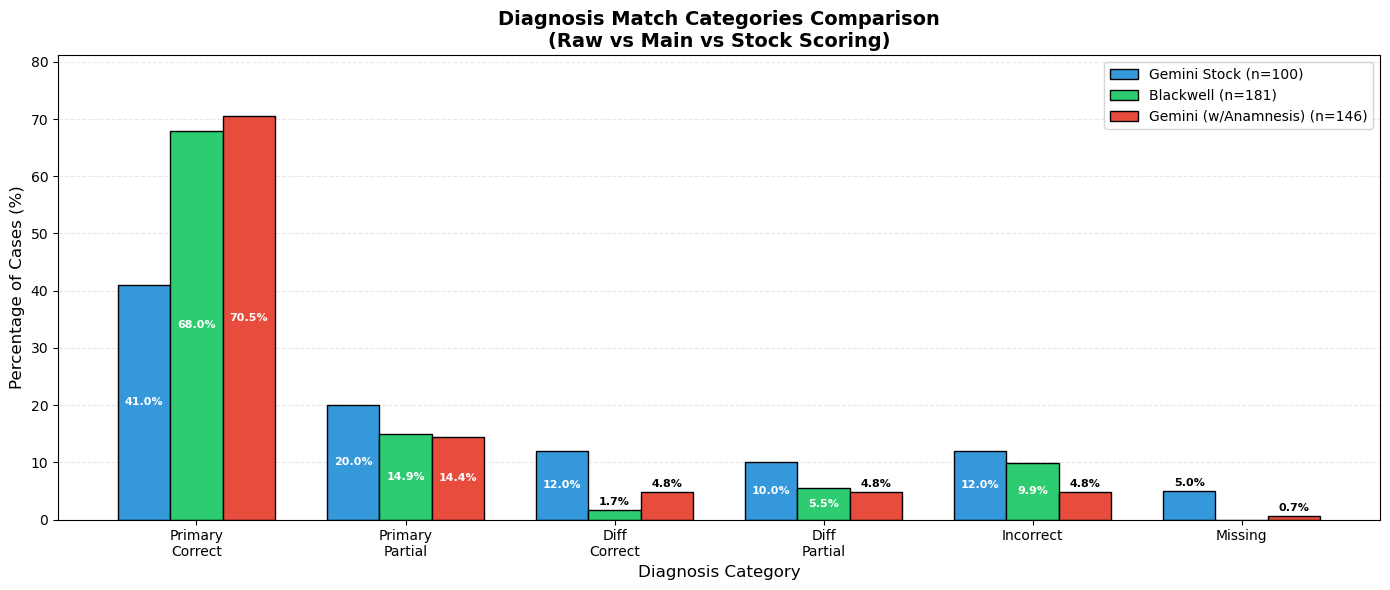

In [ ]:
# Diagnosis Match Categories Comparison (3 Datasets)
# Comparing raw gemini, blackwell, and gemini (w/a) with percentages

import numpy as np

fig, ax = plt.subplots(figsize=(14, 6))

# Category labels
categories = ['Primary\nCorrect', 'Primary\nPartial', 'Diff\nCorrect', 'Diff\nPartial', 'Incorrect', 'Missing']
category_keys = ['CORRECT', 'PARTIAL', 'DIFF_CORRECT', 'DIFF_PARTIAL', 'INCORRECT', 'MISSING']

# Calculate percentages for each dataset
datasets = {
    'Gemini Stock': raw_scored,
    'Blackwell': eval_df_scored,
    'Gemini (w/Anamnesis)': gai_scored
}

# Colors for each dataset
dataset_colors = {
    'Gemini Stock': '#3498db',      # Blue
    'Blackwell': '#2ecc71',     # Green
    'Gemini (w/Anamnesis)': '#e74c3c'     # Red
}

# Calculate percentages
percentages = {}
for name, df in datasets.items():
    total = len(df)
    counts = df['diagnosis_category'].value_counts()
    pcts = []
    for key in category_keys:
        count = counts.get(key, 0)
        pcts.append(count / total * 100 if total > 0 else 0)
    percentages[name] = pcts

# Bar positions
x = np.arange(len(categories))
width = 0.25  # Width of each bar

# Create grouped bars
for i, (name, pcts) in enumerate(percentages.items()):
    offset = (i - 1) * width  # Center the groups
    bars = ax.bar(x + offset, pcts, width, label=f'{name} (n={len(datasets[name])})', 
                  color=dataset_colors[name], edgecolor='black', linewidth=1)
    
    # Add percentage labels on bars
    for bar, pct in zip(bars, pcts):
        if pct > 0:
            # Position text inside bar if tall enough, otherwise above
            if pct > 5:
                ax.text(bar.get_x() + bar.get_width()/2, bar.get_height()/2,
                       f'{pct:.1f}%', ha='center', va='center', 
                       color='white', fontweight='bold', fontsize=8)
            else:
                ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.5,
                       f'{pct:.1f}%', ha='center', va='bottom', 
                       color='black', fontweight='bold', fontsize=8)

# Styling
ax.set_ylabel('Percentage of Cases (%)', fontsize=12)
ax.set_xlabel('Diagnosis Category', fontsize=12)
ax.set_title('Diagnosis Match Categories Comparison\n(Raw vs Main vs Stock Scoring)', fontweight='bold', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(categories, fontsize=10)
ax.legend(loc='upper right', fontsize=10)
ax.set_ylim(0, max([max(p) for p in percentages.values()]) * 1.15)  # Add 15% headroom

# Add grid for readability
ax.yaxis.grid(True, linestyle='--', alpha=0.3)
ax.set_axisbelow(True)

plt.tight_layout()
plt.savefig('evaluation/Images/evaluator-analysis/diagnosis_categories_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


## Worst Performers Investigation

Analyzing the worst performing conditions to understand why the model struggles with certain diagnoses.

In [ ]:
# ============================================================
# WORST PERFORMERS INVESTIGATION: AIDS CASES
# ============================================================
# Check if AIDS-related exams are recommended in reports where the true condition is AIDS

def extract_recommended_exams(report_text: str) -> list:
    """
    Extract the recommended exams section from a report.
    Returns a list of exam names/descriptions found.
    """
    if not report_text or pd.isna(report_text):
        return []
    
    try:
        report_text = json.loads(report_text)
    except:
        pass
    
    if not isinstance(report_text, str):
        report_text = str(report_text)
    
    exams = []
    
    # Find the recommended exams section
    section_patterns = [
        r'(?:Recommended\s+)?Exams?\s*(?:and\s+)?(?:Further\s+)?Investigation[s]?[:\s]*\n(.*?)(?=\n\s*(?:#{2,}|\*\*[A-Z]|Treatment|Management|References|$))',
        r'Further\s+Investigation[s]?[:\s]*\n(.*?)(?=\n\s*(?:#{2,}|\*\*[A-Z]|Treatment|Management|References|$))',
        r'Diagnostic\s+(?:Tests?|Workup)[:\s]*\n(.*?)(?=\n\s*(?:#{2,}|\*\*[A-Z]|Treatment|Management|References|$))',
    ]
    
    for pattern in section_patterns:
        match = re.search(pattern, report_text, re.IGNORECASE | re.DOTALL)
        if match:
            section_text = match.group(1)
            
            # Extract individual exam items
            exam_patterns = [
                r'\*\*([^\*]+)\*\*',           # **Exam Name**
                r'\d+\.\s*\*\*([^\*]+)\*\*',   # 1. **Exam Name**
                r'-\s*\*\*([^\*]+)\*\*',       # - **Exam Name**
                r'\*\s+([^\n:]+):',            # * Exam Name:
            ]
            
            for exam_pattern in exam_patterns:
                matches = re.findall(exam_pattern, section_text)
                for exam in matches:
                    exam = exam.strip()
                    if len(exam) > 3 and len(exam) < 100:
                        exams.append(exam)
            
            if exams:
                break
    
    return list(set(exams))  # Remove duplicates


def check_aids_related_exams(exams: list, report_text: str) -> dict:
    """
    Check if any AIDS/HIV related exams are mentioned.
    Returns a dict with flags for different HIV-related tests.
    """
    if not report_text:
        report_text = ""
    
    try:
        report_text = json.loads(report_text)
    except:
        pass
    
    report_lower = str(report_text).lower()
    exams_lower = ' '.join(exams).lower() if exams else ""
    combined = report_lower + " " + exams_lower
    
    return {
        'hiv_test': any(term in combined for term in ['hiv', 'human immunodeficiency']),
        'cd4_count': any(term in combined for term in ['cd4', 'cd 4', 't-cell count', 't cell count']),
        'viral_load': any(term in combined for term in ['viral load', 'hiv rna', 'hiv-rna']),
        'aids_mention': any(term in combined for term in ['aids', 'acquired immunodeficiency']),
        'elisa': 'elisa' in combined,
        'western_blot': 'western blot' in combined,
        'immunodeficiency': 'immunodeficiency' in combined or 'immune deficiency' in combined,
    }


# Get AIDS cases
aids_cases = reports[reports['true_condition'] == 'AIDS'].copy()
print("=" * 70)
print(" AIDS CASES INVESTIGATION")
print("=" * 70)
print(f"\nTotal AIDS cases in dataset: {len(aids_cases)}")

# Analyze each AIDS case
aids_analysis = []
for idx, row in aids_cases.iterrows():
    final_report = row.get('final_report', '')
    if 'EMERGENCY DETECTED' in str(row.get('anamnesis_report', '')):
        continue  # Skip emergency cases
    exams = extract_recommended_exams(final_report)
    hiv_checks = check_aids_related_exams(exams, final_report)
    
    # Get scoring info if available
    eval_row = eval_df_scored[eval_df_scored['case_index'] == idx]
    diagnosis_category = eval_row['diagnosis_category'].values[0] if len(eval_row) > 0 else 'N/A'
    extracted_diagnosis = eval_row['extracted_diagnosis'].values[0] if len(eval_row) > 0 else 'N/A'
    total_score = eval_row['total_score'].values[0] if len(eval_row) > 0 else 'N/A'
    
    aids_analysis.append({
        'case_index': idx,
        'extracted_diagnosis': extracted_diagnosis,
        'diagnosis_category': diagnosis_category,
        'total_score': total_score,
        'exams_found': exams,
        **hiv_checks
    })

aids_df = pd.DataFrame(aids_analysis)

# Summary statistics
print(f"\n HIV/AIDS EXAM DETECTION SUMMARY:")
print("-" * 50)
for col in ['hiv_test', 'cd4_count', 'viral_load', 'aids_mention', 'elisa', 'western_blot', 'immunodeficiency']:
    count = aids_df[col].sum()
    pct = count / len(aids_df) * 100 if len(aids_df) > 0 else 0
    print(f"  {col:20s}: {count:2d} / {len(aids_df)} ({pct:5.1f}%)")

# Detailed case-by-case analysis
print(f"\n\nDETAILED AIDS CASE ANALYSIS:")
print("=" * 70)
for _, row in aids_df.iterrows():
    print(f"\nCase {row['case_index']} | Category: {row['diagnosis_category']} | Score: {row['total_score']}")
    print(f"  Extracted Diagnosis: {row['extracted_diagnosis']}")
    print(f"  Recommended Exams: {row['exams_found'][:5]}..." if len(row['exams_found']) > 5 else f"  Recommended Exams: {row['exams_found']}")
    
    hiv_flags = []
    if row['hiv_test']: hiv_flags.append('HIV Test')
    if row['cd4_count']: hiv_flags.append('CD4 Count')
    if row['viral_load']: hiv_flags.append('Viral Load')
    if row['aids_mention']: hiv_flags.append('AIDS Mention')
    if row['elisa']: hiv_flags.append('ELISA')
    if row['immunodeficiency']: hiv_flags.append('Immunodeficiency')
    
    if hiv_flags:
        print(f" HIV-Related Findings: {', '.join(hiv_flags)}")
    else:
        print(f"  NO HIV-RELATED EXAMS OR MENTIONS FOUND")

🔬 AIDS CASES INVESTIGATION

Total AIDS cases in dataset: 6

 HIV/AIDS EXAM DETECTION SUMMARY:
--------------------------------------------------
  hiv_test            :  2 / 5 ( 40.0%)
  cd4_count           :  0 / 5 (  0.0%)
  viral_load          :  0 / 5 (  0.0%)
  aids_mention        :  0 / 5 (  0.0%)
  elisa               :  0 / 5 (  0.0%)
  western_blot        :  0 / 5 (  0.0%)
  immunodeficiency    :  1 / 5 ( 20.0%)


DETAILED AIDS CASE ANALYSIS:

Case 22 | Category: INCORRECT | Score: 10.0
  Extracted Diagnosis: Sepsis secondary to acute pharyngeal infection (e.g., Diphtheria or severe bacterial pharyngitis) with associated severe myositis/rhabdomyolysis.
  Recommended Exams: []
 HIV-Related Findings: HIV Test

Case 75 | Category: INCORRECT | Score: 10.0
  Extracted Diagnosis: Group A Streptococcal (GAS) Pharyngitis (Strep Throat)
  Recommended Exams: []
  NO HIV-RELATED EXAMS OR MENTIONS FOUND

Case 150 | Category: INCORRECT | Score: 10.0
  Extracted Diagnosis: Severe Infectious

In [12]:
# Deep dive into a specific AIDS case to see the full recommended exams section
print("=" * 70)
print("FULL REPORT ANALYSIS: AIDS Case with HIV Mention (Case 191)")
print("=" * 70)

# Get case 191 which had HIV mention
case_191 = reports.iloc[191]['final_report']
try:
    case_191_text = json.loads(case_191)
except:
    case_191_text = str(case_191)

# Find and print the exams section
if 'exam' in case_191_text.lower() or 'investigation' in case_191_text.lower():
    # Find the exams section
    lower_text = case_191_text.lower()
    
    # Look for section start
    section_starts = [
        lower_text.find('recommended exam'),
        lower_text.find('further investigation'),
        lower_text.find('diagnostic test'),
    ]
    section_starts = [s for s in section_starts if s > 0]
    
    if section_starts:
        start = min(section_starts)
        # Find section end (next major header or end)
        section_text = case_191_text[start:start+2500]
        print(section_text)
        print("\n" + "-" * 70)

# Also check case 22 which mentioned HIV
print("\n\n" + "=" * 70)
print("FULL REPORT ANALYSIS: AIDS Case 22")
print("=" * 70)

case_22 = reports.iloc[22]['final_report']
try:
    case_22_text = json.loads(case_22)
except:
    case_22_text = str(case_22)

# Search for HIV mentions in context
if 'hiv' in case_22_text.lower():
    lower_text = case_22_text.lower()
    hiv_idx = lower_text.find('hiv')
    print("Context around HIV mention:")
    print("-" * 40)
    print(case_22_text[max(0, hiv_idx-200):hiv_idx+500])
    print("-" * 40)

FULL REPORT ANALYSIS: AIDS Case with HIV Mention (Case 191)
Recommended Exams and Further Investigation**
Based on the significant clinical uncertainty and the need to rule out critical differentials and investigate the concerning nature of the presentation, the following investigative steps are strongly recommended. These tests are essential to transition the provisional diagnosis into a definitive one and to assess for underlying conditions.

*   **Throat Swab for Culture and Sensitivity:** This is a crucial first step to definitively identify the causative organism. The culture can confirm the presence of *Candida albicans* (or other *Candida* species), thereby confirming the diagnosis of thrush. Simultaneously, it can identify or rule out bacterial pathogens like *Streptococcus pyogenes*, directly addressing a key differential diagnosis.
*   **Rapid Strep Test:** This provides a quick, point-of-care assessment to rule out Group A Streptococcus. A negative result would further decre

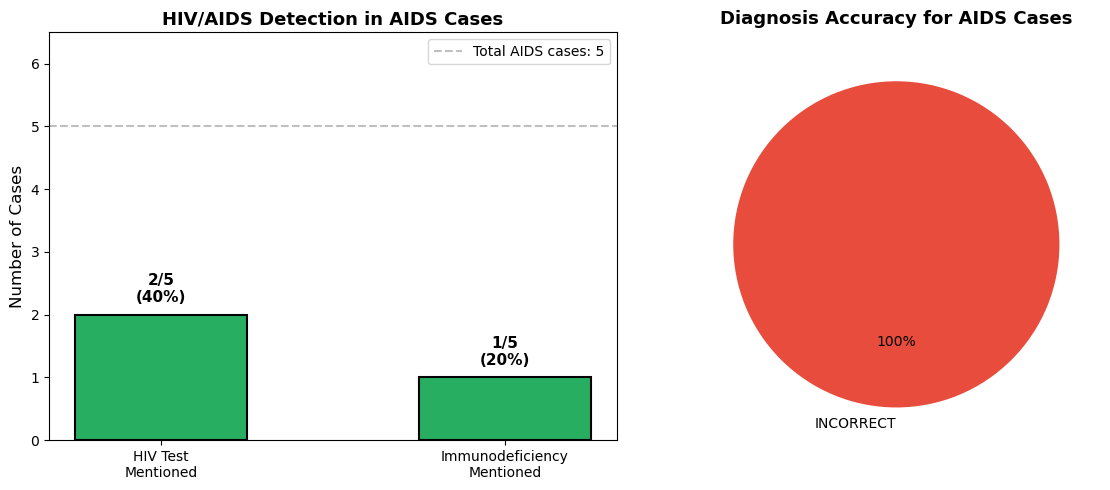

In [13]:
# AIDS Cases Investigation Visualization
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# 1. HIV-Related Exam Detection Rates (only HIV Test and Immunodeficiency)
hiv_metrics = ['HIV Test\nMentioned', 'Immunodeficiency\nMentioned']
hiv_counts = [
    aids_df['hiv_test'].sum(),
    aids_df['immunodeficiency'].sum()
]
hiv_pcts = [c / len(aids_df) * 100 for c in hiv_counts]

colors = ['#27ae60' if c > 0 else '#e74c3c' for c in hiv_counts]
bars = axes[0].bar(hiv_metrics, hiv_counts, color=colors, edgecolor='black', linewidth=1.5, width=0.5)

# Add percentage labels
for bar, pct, count in zip(bars, hiv_pcts, hiv_counts):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.15,
                f'{count}/{len(aids_df)}\n({pct:.0f}%)', ha='center', va='bottom', fontsize=11, fontweight='bold')

axes[0].set_ylabel('Number of Cases', fontsize=12)
axes[0].set_title('HIV/AIDS Detection in AIDS Cases', fontweight='bold', fontsize=13)
axes[0].set_ylim(0, len(aids_df) + 1.5)
axes[0].axhline(y=len(aids_df), color='gray', linestyle='--', alpha=0.5, label=f'Total AIDS cases: {len(aids_df)}')
axes[0].legend()

# 2. Diagnosis Distribution for AIDS Cases
diagnosis_counts = aids_df['diagnosis_category'].value_counts()
colors_map = {
    'CORRECT': '#2ecc71', 'PARTIAL': '#f39c12', 
    'DIFF_CORRECT': '#27ae60', 'DIFF_PARTIAL': '#e67e22',
    'INCORRECT': '#e74c3c', 'MISSING': '#95a5a6', 'N/A': '#bdc3c7'
}

if len(diagnosis_counts) > 0:
    colors = [colors_map.get(cat, '#3498db') for cat in diagnosis_counts.index]
    wedges, texts, autotexts = axes[1].pie(
        diagnosis_counts.values,
        labels=diagnosis_counts.index,
        colors=colors,
        autopct='%1.0f%%',
        startangle=90,
        explode=[0.05] * len(diagnosis_counts)
    )
    axes[1].set_title('Diagnosis Accuracy for AIDS Cases', fontweight='bold', fontsize=13)
else:
    axes[1].text(0.5, 0.5, 'No data', ha='center', va='center', transform=axes[1].transAxes)

plt.tight_layout()
plt.savefig('evaluation/Images/evaluator-analysis/aids_investigation.png', dpi=300, bbox_inches='tight')
plt.show()


### Hepatitis Cases Investigation

Investigating how well the evaluator handles Hepatitis B, C, and D cases - checking if appropriate liver function tests and hepatitis panels are recommended.

In [22]:
# Hepatitis Cases Investigation
# Filter for Hepatitis B, C, and D cases
hepatitis_conditions = ['Hepatitis B', 'Hepatitis C', 'Hepatitis D']
hepatitis_cases = reports[reports['true_condition'].isin(hepatitis_conditions)].copy()
if "Emergency Detected" in hepatitis_cases['final_report'].values:
    hepatitis_cases = hepatitis_cases[~hepatitis_cases['final_report'].str.contains("Emergency Detected")]
print("=" * 70)
print("HEPATITIS CASES INVESTIGATION")
print("=" * 70)
print(f"\nTotal Hepatitis cases: {len(hepatitis_cases)}")
print(f"  - Hepatitis B: {len(hepatitis_cases[hepatitis_cases['true_condition'] == 'Hepatitis B'])}")
print(f"  - Hepatitis C: {len(hepatitis_cases[hepatitis_cases['true_condition'] == 'Hepatitis C'])}")
print(f"  - Hepatitis D: {len(hepatitis_cases[hepatitis_cases['true_condition'] == 'Hepatitis D'])}")

def check_hepatitis_related_exams(report_text: str) -> dict:
    """
    Check if any Hepatitis/Liver related exams are mentioned.
    Returns a dict with flags for different hepatitis-related tests.
    """
    if not report_text:
        report_text = ""
    
    try:
        report_text = json.loads(report_text)
    except:
        pass
    
    report_lower = str(report_text).lower()
    
    return {
        'hepatitis_test': any(term in report_lower for term in ['hepatitis test', 'hepatitis panel', 'hepatitis screening', 'hep b', 'hep c', 'hbv', 'hcv', 'hdv']),
        'liver_function': any(term in report_lower for term in ['liver function', 'lft', 'alt', 'ast', 'bilirubin', 'albumin', 'hepatic panel', 'liver enzyme']),
    }

# Analyze each hepatitis case
hepatitis_analysis = []
for idx, row in hepatitis_cases.iterrows():
    final_report = row.get('final_report', '')
    if 'EMERGENCY DETECTED' in str(row.get('anamnesis_report', '')):
        continue  # Skip emergency cases
    hep_checks = check_hepatitis_related_exams(final_report)
    
    # Get scoring info if available
    eval_row = eval_df_scored[eval_df_scored['case_index'] == idx]
    diagnosis_category = eval_row['diagnosis_category'].values[0] if len(eval_row) > 0 else 'N/A'
    extracted_diagnosis = eval_row['extracted_diagnosis'].values[0] if len(eval_row) > 0 else 'N/A'
    total_score = eval_row['total_score'].values[0] if len(eval_row) > 0 else 'N/A'
    
    hepatitis_analysis.append({
        'case_index': idx,
        'condition': row['true_condition'],
        'extracted_diagnosis': extracted_diagnosis,
        'diagnosis_category': diagnosis_category,
        'total_score': total_score,
        **hep_checks
    })

hepatitis_df = pd.DataFrame(hepatitis_analysis)

# Summary statistics
print("\n" + "-" * 70)
print("HEPATITIS TEST DETECTION RATES:")
print("-" * 70)
print(f"  Hepatitis Test/Panel mentioned: {hepatitis_df['hepatitis_test'].sum()}/{len(hepatitis_df)} ({hepatitis_df['hepatitis_test'].sum()/len(hepatitis_df)*100:.1f}%)")
print(f"  Liver Function Tests mentioned: {hepatitis_df['liver_function'].sum()}/{len(hepatitis_df)} ({hepatitis_df['liver_function'].sum()/len(hepatitis_df)*100:.1f}%)")

# Diagnosis accuracy
print("\n" + "-" * 70)
print("DIAGNOSIS ACCURACY FOR HEPATITIS CASES:")
print("-" * 70)
diag_counts = hepatitis_df['diagnosis_category'].value_counts()
for cat, count in diag_counts.items():
    print(f"  {cat}: {count} ({count/len(hepatitis_df)*100:.1f}%)")

# Break down by hepatitis type
print("\n" + "-" * 70)
print("BY HEPATITIS TYPE:")
print("-" * 70)
for hep_type in hepatitis_conditions:
    hep_subset = hepatitis_df[hepatitis_df['condition'] == hep_type]
    if len(hep_subset) > 0:
        correct = (hep_subset['diagnosis_category'].isin(['CORRECT', 'PARTIAL', 'DIFF_CORRECT', 'DIFF_PARTIAL'])).sum()
        hep_test_rate = hep_subset['hepatitis_test'].sum() / len(hep_subset) * 100
        liver_test_rate = hep_subset['liver_function'].sum() / len(hep_subset) * 100
        print(f"\n  {hep_type} ({len(hep_subset)} cases):")
        print(f"    - Correct/Partial: {correct}/{len(hep_subset)} ({correct/len(hep_subset)*100:.0f}%)")
        print(f"    - Hepatitis Test Rate: {hep_subset['hepatitis_test'].sum()}/{len(hep_subset)} ({hep_test_rate:.0f}%)")
        print(f"    - Liver Function Test Rate: {hep_subset['liver_function'].sum()}/{len(hep_subset)} ({liver_test_rate:.0f}%)")

# Show individual cases
print("\n" + "=" * 70)
print("INDIVIDUAL HEPATITIS CASE DETAILS:")
print("=" * 70)
for _, case in hepatitis_df.iterrows():
    hep_flag = "✅" if case['hepatitis_test'] else "❌"
    liver_flag = "✅" if case['liver_function'] else "❌"
    status_emoji = "✅" if case['diagnosis_category'] in ['CORRECT', 'PARTIAL', 'DIFF_CORRECT', 'DIFF_PARTIAL'] else "❌"
    
    print(f"\nCase {case['case_index']} - {case['condition']}:")
    print(f"  Status: {status_emoji} {case['diagnosis_category']}")
    print(f"  Extracted Diagnosis: {case['extracted_diagnosis']}")
    print(f"  Hepatitis Test: {hep_flag} | Liver Function: {liver_flag}")
    print(f"  Score: {case['total_score']}")

HEPATITIS CASES INVESTIGATION

Total Hepatitis cases: 20
  - Hepatitis B: 4
  - Hepatitis C: 6
  - Hepatitis D: 10

----------------------------------------------------------------------
HEPATITIS TEST DETECTION RATES:
----------------------------------------------------------------------
  Hepatitis Test/Panel mentioned: 6/16 (37.5%)
  Liver Function Tests mentioned: 16/16 (100.0%)

----------------------------------------------------------------------
DIAGNOSIS ACCURACY FOR HEPATITIS CASES:
----------------------------------------------------------------------
  INCORRECT: 8 (50.0%)
  CORRECT: 3 (18.8%)
  DIFF_PARTIAL: 2 (12.5%)
  PARTIAL: 2 (12.5%)
  DIFF_CORRECT: 1 (6.2%)

----------------------------------------------------------------------
BY HEPATITIS TYPE:
----------------------------------------------------------------------

  Hepatitis B (4 cases):
    - Correct/Partial: 2/4 (50%)
    - Hepatitis Test Rate: 0/4 (0%)
    - Liver Function Test Rate: 4/4 (100%)

  Hepatitis C 

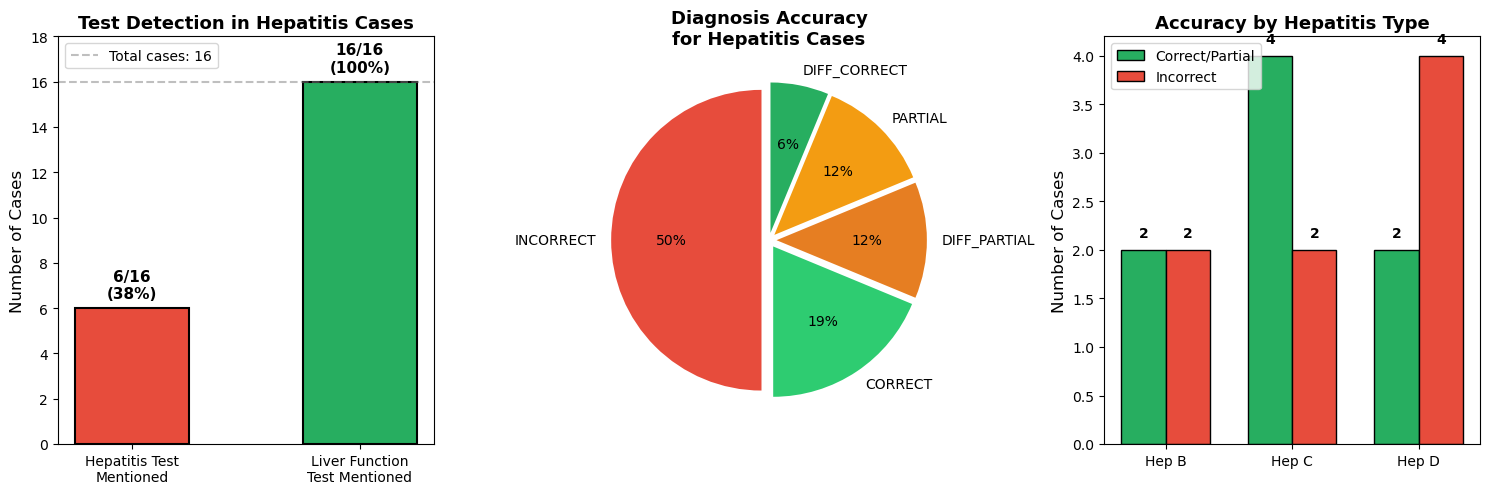

In [23]:
# Hepatitis Cases Investigation Visualization
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# 1. Hepatitis Test Detection Rates (only Hepatitis Test and Liver Function)
hep_metrics = ['Hepatitis Test\nMentioned', 'Liver Function\nTest Mentioned']
hep_counts = [
    hepatitis_df['hepatitis_test'].sum(),
    hepatitis_df['liver_function'].sum()
]
hep_pcts = [c / len(hepatitis_df) * 100 for c in hep_counts]

colors = ['#27ae60' if pct >= 50 else '#e74c3c' for pct in hep_pcts]
bars = axes[0].bar(hep_metrics, hep_counts, color=colors, edgecolor='black', linewidth=1.5, width=0.5)

# Add percentage labels
for bar, pct, count in zip(bars, hep_pcts, hep_counts):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3,
                f'{count}/{len(hepatitis_df)}\n({pct:.0f}%)', ha='center', va='bottom', fontsize=11, fontweight='bold')

axes[0].set_ylabel('Number of Cases', fontsize=12)
axes[0].set_title('Test Detection in Hepatitis Cases', fontweight='bold', fontsize=13)
axes[0].set_ylim(0, len(hepatitis_df) + 2)
axes[0].axhline(y=len(hepatitis_df), color='gray', linestyle='--', alpha=0.5, label=f'Total cases: {len(hepatitis_df)}')
axes[0].legend()

# 2. Diagnosis Distribution for Hepatitis Cases
diagnosis_counts = hepatitis_df['diagnosis_category'].value_counts()
colors_map = {
    'CORRECT': '#2ecc71', 'PARTIAL': '#f39c12', 
    'DIFF_CORRECT': '#27ae60', 'DIFF_PARTIAL': '#e67e22',
    'INCORRECT': '#e74c3c', 'MISSING': '#95a5a6', 'N/A': '#bdc3c7'
}

if len(diagnosis_counts) > 0:
    colors = [colors_map.get(cat, '#3498db') for cat in diagnosis_counts.index]
    wedges, texts, autotexts = axes[1].pie(
        diagnosis_counts.values,
        labels=diagnosis_counts.index,
        colors=colors,
        autopct='%1.0f%%',
        startangle=90,
        explode=[0.05] * len(diagnosis_counts)
    )
    axes[1].set_title('Diagnosis Accuracy\nfor Hepatitis Cases', fontweight='bold', fontsize=13)

# 3. Breakdown by Hepatitis Type
hep_types = ['Hepatitis B', 'Hepatitis C', 'Hepatitis D']
correct_counts = []
incorrect_counts = []
hep_test_rates = []

for hep_type in hep_types:
    subset = hepatitis_df[hepatitis_df['condition'] == hep_type]
    if len(subset) > 0:
        correct = subset['diagnosis_category'].isin(['CORRECT', 'PARTIAL', 'DIFF_CORRECT', 'DIFF_PARTIAL']).sum()
        incorrect = len(subset) - correct
        correct_counts.append(correct)
        incorrect_counts.append(incorrect)
    else:
        correct_counts.append(0)
        incorrect_counts.append(0)

x = np.arange(len(hep_types))
width = 0.35

bars1 = axes[2].bar(x - width/2, correct_counts, width, label='Correct/Partial', color='#27ae60', edgecolor='black')
bars2 = axes[2].bar(x + width/2, incorrect_counts, width, label='Incorrect', color='#e74c3c', edgecolor='black')

axes[2].set_ylabel('Number of Cases', fontsize=12)
axes[2].set_title('Accuracy by Hepatitis Type', fontweight='bold', fontsize=13)
axes[2].set_xticks(x)
axes[2].set_xticklabels(['Hep B', 'Hep C', 'Hep D'])
axes[2].legend()

# Add count labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            axes[2].text(bar.get_x() + bar.get_width()/2, height + 0.1,
                        f'{int(height)}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('evaluation/Images/evaluator-analysis/hepatitis_investigation.png', dpi=300, bbox_inches='tight')
plt.show()


## Treatment Plan Evaluation

Evaluating treatment recommendations using two approaches:
1. **Keyword/Category Matching**: Check if treatments mention expected categories for certain conditions
2. **Structured Checklist**: Score based on completeness of treatment components

In [ ]:

# TREATMENT PLAN EVALUATION (SEMANTIC SIMILARITY)
# Define expected treatment descriptions by condition type
# Using full treatment phrases for better semantic matching
CONDITION_TREATMENT_MAPPING = {
    # Infections
    'AIDS': [
        'antiretroviral therapy ART',
        'CD4 count monitoring',
        'opportunistic infection prophylaxis',
        'viral load monitoring',
        'immune system support'
    ],
    'Hepatitis B': [
        'antiviral therapy entecavir or tenofovir',
        'interferon alpha treatment',
        'liver function monitoring',
        'hepatitis B vaccination for contacts'
    ],
    'Hepatitis C': [
        'direct-acting antiviral therapy',
        'sofosbuvir ledipasvir combination',
        'liver function monitoring',
        'hepatitis C cure assessment'
    ],
    'Hepatitis D': [
        'pegylated interferon alpha',
        'antiviral therapy',
        'liver disease monitoring'
    ],
    'Pneumonia': [
        'antibiotic therapy',
        'oxygen supplementation if hypoxic',
        'respiratory support',
        'hydration and rest'
    ],
    'Tuberculosis': [
        'RIPE therapy rifampin isoniazid pyrazinamide ethambutol',
        'directly observed therapy DOT',
        'anti-tuberculosis medication',
        'contact tracing and screening'
    ],
    'Urinary tract infection': [
        'antibiotic therapy fluoroquinolone or nitrofurantoin',
        'increased fluid intake',
        'urinalysis follow-up'
    ],
    'Common Cold': [
        'symptomatic treatment rest and fluids',
        'decongestants for nasal congestion',
        'analgesics for pain and fever',
        'self-limiting illness supportive care'
    ],
    'Influenza': [
        'antiviral therapy oseltamivir Tamiflu',
        'symptomatic treatment',
        'rest and hydration',
        'isolation to prevent spread'
    ],
    
    # Cardiovascular
    'Hypertension': [
        'antihypertensive medication',
        'ACE inhibitor or ARB therapy',
        'lifestyle modification diet and exercise',
        'blood pressure monitoring',
        'sodium restriction DASH diet'
    ],
    'Heart attack': [
        'antiplatelet therapy aspirin clopidogrel',
        'thrombolytic therapy or PCI',
        'cardiac catheterization stent placement',
        'cardiac rehabilitation'
    ],
    
    # Metabolic/Endocrine
    'Diabetes': [
        'insulin therapy or oral hypoglycemics metformin',
        'blood glucose monitoring',
        'dietary management carbohydrate control',
        'lifestyle modification exercise',
        'HbA1c monitoring'
    ],
    'Hyperthyroidism': [
        'antithyroid medication methimazole PTU',
        'radioactive iodine ablation',
        'beta blockers for symptom control',
        'thyroid function monitoring'
    ],
    'Hypothyroidism': [
        'levothyroxine thyroid hormone replacement',
        'TSH monitoring and dose adjustment',
        'lifelong therapy'
    ],
    
    # Gastrointestinal
    'Gastroesophageal reflux disease': [
        'proton pump inhibitor PPI therapy',
        'lifestyle modifications avoid triggers',
        'dietary changes smaller meals',
        'H2 receptor antagonist'
    ],
    'Peptic ulcer disease': [
        'proton pump inhibitor therapy',
        'H. pylori eradication triple therapy',
        'avoid NSAIDs and irritants',
        'antacid therapy'
    ],
    
    # Respiratory
    'Asthma': [
        'inhaled corticosteroid controller medication',
        'short-acting beta agonist rescue inhaler',
        'asthma action plan',
        'trigger avoidance'
    ],
    'COPD': [
        'bronchodilator therapy inhaler',
        'inhaled corticosteroid if indicated',
        'supplemental oxygen therapy',
        'pulmonary rehabilitation',
        'smoking cessation'
    ],
    
    # Pain/Musculoskeletal
    'Osteoarthritis': [
        'NSAID anti-inflammatory pain management',
        'physical therapy exercises',
        'weight management',
        'joint protection strategies'
    ],
    'Migraine': [
        'triptan therapy for acute attacks',
        'prophylactic medication if frequent',
        'trigger identification and avoidance',
        'analgesic therapy'
    ],
    
    # Mental Health
    'Anxiety': [
        'SSRI or anxiolytic medication',
        'cognitive behavioral therapy CBT',
        'relaxation techniques',
        'lifestyle modifications stress management'
    ],
    'Depression': [
        'antidepressant medication SSRI SNRI',
        'psychotherapy counseling',
        'cognitive behavioral therapy',
        'lifestyle modifications exercise sleep'
    ],
    
    # Allergies
    'Allergy': [
        'antihistamine therapy',
        'allergen avoidance',
        'corticosteroid if severe',
        'epinephrine for anaphylaxis'
    ],
    'Drug Reaction': [
        'discontinue offending medication',
        'antihistamine therapy',
        'corticosteroid if needed',
        'alternative medication selection'
    ],
}

# Treatment similarity threshold
TREATMENT_SIMILARITY_THRESHOLD = 0.8

def extract_treatment_section(report_text: str) -> str:
    """Extract the treatment/management section from a report."""
    if not report_text or pd.isna(report_text):
        return ""
    
    # Parse JSON-escaped string if needed
    try:
        report_text = json.loads(report_text)
    except:
        pass
    
    if not isinstance(report_text, str):
        report_text = str(report_text)
    
    # Split by section headers (### **N. Title**)
    sections = re.split(r'\n###\s+', report_text)
    
    # Find the management/treatment section
    for section in sections:
        section_lower = section.lower()[:150]
        if any(kw in section_lower for kw in ['management plan', 'treatment', 'therapeutic']):
            return section
    
    # Fallback: look for any treatment-related content
    treatment_patterns = [
        r'\*\*(?:\d+\.\s*)?(?:Recommended\s+)?Management\s+Plan[^*]*\*\*(.*?)(?=\n###|\n\*\*\d+\.|$)',
        r'\*\*Treatment\s+(?:Plan|Recommendations?)\*\*(.*?)(?=\n###|\n\*\*\d+\.|$)',
    ]
    
    for pattern in treatment_patterns:
        match = re.search(pattern, report_text, re.IGNORECASE | re.DOTALL)
        if match:
            return match.group(1).strip()
    
    return ""

def evaluate_treatment_checklist(treatment_text: str) -> dict:
    """
    Evaluate treatment section against structured checklist.
    Returns scores for each component.
    """
    if not treatment_text:
        return {
            'has_treatment': False,
            'has_medication': False,
            'has_dosage': False,
            'has_duration': False,
            'has_follow_up': False,
            'has_lifestyle': False,
            'has_warning_signs': False,
            'has_monitoring': False,
            'checklist_score': 0,
            'checklist_max': 7
        }
    
    treatment_lower = treatment_text.lower()
    
    # Check for specific components
    has_medication = bool(re.search(r'\b(?:mg|mcg|ml|tablet|capsule|dose|medication|drug|prescribe|administer|antibiotic|antiviral|steroid|therapy)\b', treatment_lower))
    has_dosage = bool(re.search(r'\b(?:\d+\s*(?:mg|mcg|ml|g|units?)|times?\s*(?:daily|per day|a day)|once|twice|every|q\d+h|bid|tid|qid)\b', treatment_lower))
    has_duration = bool(re.search(r'\b(?:\d+\s*(?:days?|weeks?|months?)|course|duration|for\s+\d+|continue\s+for|short[\s-]?term|long[\s-]?term)\b', treatment_lower))
    has_follow_up = bool(re.search(r'\b(?:follow[\s-]?up|return|revisit|schedule|appointment|check[\s-]?up|reassess|review|outpatient)\b', treatment_lower))
    has_lifestyle = bool(re.search(r'\b(?:diet|exercise|lifestyle|weight|smoking|alcohol|stress|sleep|activity|rest|hydration|avoid|abstain|cease)\b', treatment_lower))
    has_warning_signs = bool(re.search(r'\b(?:warning|red flag|seek|emergency|worsen|if\s+symptoms?|call\s+(?:doctor|physician)|return\s+if|immediately|urgent)\b', treatment_lower))
    has_monitoring = bool(re.search(r'\b(?:monitor|measure|check|test|lab|blood\s+(?:pressure|sugar|glucose)|vital|repeat|recheck)\b', treatment_lower))
    
    # Calculate score (sum of 7 components)
    components = [has_medication, has_dosage, has_duration, has_follow_up, has_lifestyle, has_warning_signs, has_monitoring]
    checklist_score = sum(components)
    
    return {
        'has_treatment': True,
        'has_medication': has_medication,
        'has_dosage': has_dosage,
        'has_duration': has_duration,
        'has_follow_up': has_follow_up,
        'has_lifestyle': has_lifestyle,
        'has_warning_signs': has_warning_signs,
        'has_monitoring': has_monitoring,
        'checklist_score': checklist_score,
        'checklist_max': 7
    }

def evaluate_treatment_category_match(treatment_text: str, condition: str, 
                                       treatment_embeddings_cache: dict = None) -> dict:
    """
    Check if treatment matches expected treatments using semantic similarity.
    Uses embeddings to capture synonyms and paraphrases.
    """
    if not treatment_text or condition not in CONDITION_TREATMENT_MAPPING:
        return {
            'category_match': False,
            'matched_treatments': [],
            'match_scores': [],
            'expected_treatments': CONDITION_TREATMENT_MAPPING.get(condition, []),
            'best_match_score': 0.0,
            'avg_match_score': 0.0
        }
    
    expected_treatments = CONDITION_TREATMENT_MAPPING[condition]
    
    # Split treatment text into meaningful segments
    treatment_segments = [seg.strip() for seg in re.split(r'[.\n•*-]', treatment_text) if seg.strip() and len(seg.strip()) > 10]
    
    if not treatment_segments:
        treatment_segments = [treatment_text]
    
    # Get embeddings for treatment segments
    try:
        segment_embeddings = np.array(embed_texts(treatment_segments))
        if segment_embeddings.size == 0:
            raise ValueError("No embeddings generated for treatment segments")
    except Exception as e:
        # Fallback to keyword matching if embedding fails
        treatment_lower = treatment_text.lower()
        matched = []
        for exp in expected_treatments:
            # Check if any word from expected treatment appears in text
            words = exp.lower().split()
            if any(word in treatment_lower for word in words if len(word) > 3):
                matched.append(exp)
        return {
            'category_match': len(matched) > 0,
            'matched_treatments': matched,
            'match_scores': [0.5] * len(matched),  # Placeholder scores for keyword match
            'expected_treatments': expected_treatments,
            'best_match_score': 0.5 if matched else 0.0,
            'avg_match_score': 0.5 if matched else 0.0,
            'fallback': True
        }
    
    # Get embeddings for expected treatments (use cache if provided)
    cache_key = condition
    if treatment_embeddings_cache is not None and cache_key in treatment_embeddings_cache:
        expected_embeddings = treatment_embeddings_cache[cache_key]
    else:
        try:
            expected_embeddings = np.array(embed_texts(expected_treatments))
            if treatment_embeddings_cache is not None:
                treatment_embeddings_cache[cache_key] = expected_embeddings
        except Exception as e:
            return {
                'category_match': False,
                'matched_treatments': [],
                'match_scores': [],
                'expected_treatments': expected_treatments,
                'best_match_score': 0.0,
                'avg_match_score': 0.0,
                'error': str(e)
            }
    
    if expected_embeddings.size == 0:
        return {
            'category_match': False,
            'matched_treatments': [],
            'match_scores': [],
            'expected_treatments': expected_treatments,
            'best_match_score': 0.0,
            'avg_match_score': 0.0
        }
    
    # Calculate similarity for each expected treatment
    matched_treatments = []
    match_scores = []
    
    segment_norms = np.linalg.norm(segment_embeddings, axis=1)
    segment_norms = np.where(segment_norms == 0, 1e-10, segment_norms)
    
    for i, exp_embedding in enumerate(expected_embeddings):
        exp_norm = np.linalg.norm(exp_embedding)
        if exp_norm == 0:
            continue
        
        # Calculate cosine similarity with all segments
        similarities = (segment_embeddings @ exp_embedding) / (segment_norms * exp_norm)
        best_sim = float(np.max(similarities))
        
        if best_sim >= TREATMENT_SIMILARITY_THRESHOLD:
            matched_treatments.append(expected_treatments[i])
            match_scores.append(best_sim)
    
    best_match = max(match_scores) if match_scores else 0.0
    avg_match = np.mean(match_scores) if match_scores else 0.0
    
    return {
        'category_match': len(matched_treatments) > 0,
        'matched_treatments': matched_treatments,
        'match_scores': match_scores,
        'expected_treatments': expected_treatments,
        'best_match_score': best_match,
        'avg_match_score': avg_match,
        'match_rate': len(matched_treatments) / len(expected_treatments) if expected_treatments else 0.0
    }

In [ ]:
# Run treatment evaluation on all reports (with semantic similarity)
treatment_results = []
treatment_embeddings_cache = {}  # Cache for expected treatment embeddings

print("Running treatment evaluation with semantic similarity...")
print("(This may take a moment due to embedding API calls)")

for idx, row in reports.iterrows():
    final_report = row.get('final_report', '')
    condition = row.get('true_condition', '')
    
    # Skip emergency cases
    if 'EMERGENCY DETECTED' in str(row.get('anamnesis_report', '')):
        continue
    
    # Extract treatment section
    treatment_text = extract_treatment_section(final_report)
    
    # Evaluate checklist
    checklist = evaluate_treatment_checklist(treatment_text)
    
    # Evaluate category match using semantic similarity
    category = evaluate_treatment_category_match(treatment_text, condition, treatment_embeddings_cache)
    
    # Get diagnosis info from scored dataframe
    eval_row = eval_df_scored[eval_df_scored['case_index'] == idx]
    diagnosis_category = eval_row['diagnosis_category'].values[0] if len(eval_row) > 0 else 'N/A'
    
    treatment_results.append({
        'case_index': idx,
        'condition': condition,
        'diagnosis_category': diagnosis_category,
        'treatment_length': len(treatment_text),
        **checklist,
        **{f'cat_{k}': v for k, v in category.items()}
    })

    time.sleep(0.2)  # To avoid hitting rate limits

treatment_df = pd.DataFrame(treatment_results)


# Filter out cases without treatment sections
with_treatment = treatment_df[treatment_df['has_treatment']]
print(f"\nReports with treatment section: {len(with_treatment)}/{len(treatment_df)} ({len(with_treatment)/len(treatment_df)*100:.1f}%)")

print("\n" + "-" * 70)
print("STRUCTURED CHECKLIST RESULTS:")
print("-" * 70)
components = ['has_medication', 'has_dosage', 'has_duration', 'has_follow_up', 'has_lifestyle', 'has_warning_signs', 'has_monitoring']
component_labels = ['Medication Names', 'Dosages Specified', 'Treatment Duration', 'Follow-up Plan', 'Lifestyle Advice', 'Warning Signs', 'Monitoring Plan']

for comp, label in zip(components, component_labels):
    count = with_treatment[comp].sum()
    pct = count / len(with_treatment) * 100 if len(with_treatment) > 0 else 0
    bar = "█" * int(pct / 5) + "░" * (20 - int(pct / 5))
    print(f"  {label:20s}: {bar} {count:3d}/{len(with_treatment)} ({pct:5.1f}%)")

print(f"\n  Average Checklist Score: {with_treatment['checklist_score'].mean():.2f}/7")

print("\n" + "-" * 70)
print("SEMANTIC TREATMENT MATCHING RESULTS (for known conditions):")
print("-" * 70)
with_known_condition = treatment_df[treatment_df['condition'].isin(CONDITION_TREATMENT_MAPPING.keys())]
print(f"  Cases with known condition mapping: {len(with_known_condition)}")
if len(with_known_condition) > 0:
    cat_match_rate = with_known_condition['cat_category_match'].sum() / len(with_known_condition) * 100
    avg_match_rate = with_known_condition['cat_match_rate'].mean() * 100
    avg_best_score = with_known_condition['cat_best_match_score'].mean()
    print(f"  Cases with semantic treatment match: {with_known_condition['cat_category_match'].sum()} ({cat_match_rate:.1f}%)")
    print(f"  Average treatment match rate: {avg_match_rate:.1f}%")
    print(f"  Average best similarity score: {avg_best_score:.3f}")
    print(f"  Similarity threshold: {TREATMENT_SIMILARITY_THRESHOLD}")

# Breakdown by diagnosis accuracy
print("\n" + "-" * 70)
print("CHECKLIST SCORE BY DIAGNOSIS ACCURACY:")
print("-" * 70)
for cat in ['CORRECT', 'PARTIAL', 'DIFF_CORRECT', 'DIFF_PARTIAL', 'INCORRECT']:
    subset = with_treatment[with_treatment['diagnosis_category'] == cat]
    if len(subset) > 0:
        avg_score = subset['checklist_score'].mean()
        print(f"  {cat:15s}: {avg_score:.2f}/7 (n={len(subset)})")

Running treatment evaluation with semantic similarity...
(This may take a moment due to embedding API calls)
Embedding call failed for 48 texts: Error embedding content: Timeout of 60.0s exceeded, last exception: 503 failed to connect to all addresses; last error: UNAVAILABLE: ipv4:209.85.202.95:443: TCP stream shutting down
Embedding call failed for 48 texts: Error embedding content: Timeout of 60.0s exceeded, last exception: 503 failed to connect to all addresses; last error: UNAVAILABLE: ipv4:209.85.202.95:443: TCP stream shutting down
📋 TREATMENT PLAN EVALUATION SUMMARY

Reports with treatment section: 181/181 (100.0%)

----------------------------------------------------------------------
STRUCTURED CHECKLIST RESULTS:
----------------------------------------------------------------------
  Medication Names    : ███████████████████░ 176/181 ( 97.2%)
  Dosages Specified   : ██████████░░░░░░░░░░  91/181 ( 50.3%)
  Treatment Duration  : ██████████████████░░ 163/181 ( 90.1%)
  Follow-u

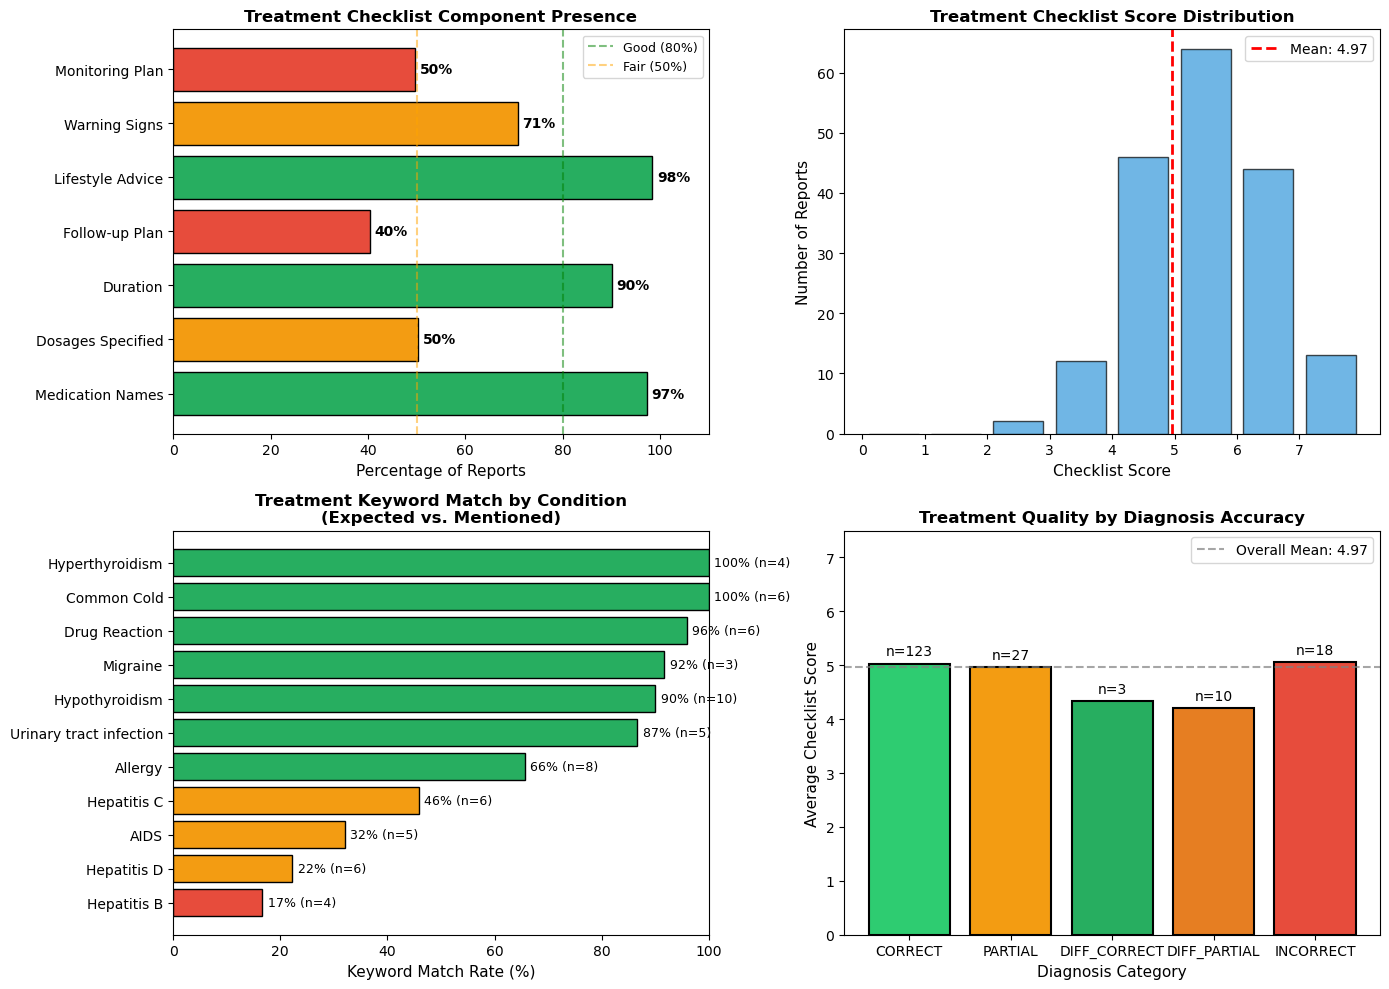

In [27]:
# Treatment Plan Evaluation Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# 1. Checklist Component Rates (Horizontal Bar Chart)
components = ['Medication Names', 'Dosages Specified', 'Duration', 'Follow-up Plan', 
              'Lifestyle Advice', 'Warning Signs', 'Monitoring Plan']
component_cols = ['has_medication', 'has_dosage', 'has_duration', 'has_follow_up', 
                  'has_lifestyle', 'has_warning_signs', 'has_monitoring']

with_treatment = treatment_df[treatment_df['has_treatment']]
rates = [with_treatment[col].sum() / len(with_treatment) * 100 for col in component_cols]

colors = ['#27ae60' if r >= 80 else '#f39c12' if r >= 50 else '#e74c3c' for r in rates]
bars = axes[0, 0].barh(components, rates, color=colors, edgecolor='black', linewidth=1)

# Add percentage labels
for bar, rate in zip(bars, rates):
    axes[0, 0].text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2, 
                    f'{rate:.0f}%', va='center', fontweight='bold')

axes[0, 0].set_xlabel('Percentage of Reports', fontsize=11)
axes[0, 0].set_title('Treatment Checklist Component Presence', fontweight='bold', fontsize=12)
axes[0, 0].set_xlim(0, 110)
axes[0, 0].axvline(x=80, color='green', linestyle='--', alpha=0.5, label='Good (80%)')
axes[0, 0].axvline(x=50, color='orange', linestyle='--', alpha=0.5, label='Fair (50%)')
axes[0, 0].legend(loc='upper right', fontsize=9)

# 2. Checklist Score Distribution
scores = with_treatment['checklist_score']
axes[0, 1].hist(scores, bins=range(0, 9), color='#3498db', edgecolor='black', alpha=0.7, rwidth=0.8)
axes[0, 1].axvline(x=scores.mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {scores.mean():.2f}')
axes[0, 1].set_xlabel('Checklist Score', fontsize=11)
axes[0, 1].set_ylabel('Number of Reports', fontsize=11)
axes[0, 1].set_title('Treatment Checklist Score Distribution', fontweight='bold', fontsize=12)
axes[0, 1].set_xticks(range(0, 8))
axes[0, 1].legend()

# 3. Category Match Rate by Condition
known_conditions = treatment_df[treatment_df['condition'].isin(CONDITION_TREATMENT_MAPPING.keys())].copy()
if len(known_conditions) > 0:
    condition_match = known_conditions.groupby('condition').agg({
        'cat_category_match': 'mean',
        'cat_match_rate': 'mean',
        'case_index': 'count'
    }).rename(columns={'case_index': 'count'})
    condition_match = condition_match[condition_match['count'] >= 2].sort_values('cat_match_rate', ascending=True)
    
    if len(condition_match) > 0:
        y_pos = range(len(condition_match))
        colors = ['#27ae60' if r >= 0.5 else '#f39c12' if r >= 0.2 else '#e74c3c' for r in condition_match['cat_match_rate']]
        bars = axes[1, 0].barh(condition_match.index, condition_match['cat_match_rate'] * 100, 
                               color=colors, edgecolor='black')
        
        for bar, (idx, row) in zip(bars, condition_match.iterrows()):
            axes[1, 0].text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2,
                           f'{row["cat_match_rate"]*100:.0f}% (n={int(row["count"])})', va='center', fontsize=9)
        
        axes[1, 0].set_xlabel('Keyword Match Rate (%)', fontsize=11)
        axes[1, 0].set_title('Treatment Keyword Match by Condition\n(Expected vs. Mentioned)', fontweight='bold', fontsize=12)
        axes[1, 0].set_xlim(0, 100)
    else:
        axes[1, 0].text(0.5, 0.5, 'Insufficient data', ha='center', va='center', transform=axes[1, 0].transAxes)
else:
    axes[1, 0].text(0.5, 0.5, 'No matching conditions', ha='center', va='center', transform=axes[1, 0].transAxes)

# 4. Treatment Quality vs Diagnosis Accuracy
diag_categories = ['CORRECT', 'PARTIAL', 'DIFF_CORRECT', 'DIFF_PARTIAL', 'INCORRECT']
avg_scores = []
counts = []
for cat in diag_categories:
    subset = with_treatment[with_treatment['diagnosis_category'] == cat]
    if len(subset) > 0:
        avg_scores.append(subset['checklist_score'].mean())
        counts.append(len(subset))
    else:
        avg_scores.append(0)
        counts.append(0)

colors = ['#2ecc71', '#f39c12', '#27ae60', '#e67e22', '#e74c3c']
bars = axes[1, 1].bar(diag_categories, avg_scores, color=colors, edgecolor='black', linewidth=1.5)

for bar, count in zip(bars, counts):
    if count > 0:
        axes[1, 1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
                       f'n={count}', ha='center', va='bottom', fontsize=10)

axes[1, 1].set_ylabel('Average Checklist Score', fontsize=11)
axes[1, 1].set_xlabel('Diagnosis Category', fontsize=11)
axes[1, 1].set_title('Treatment Quality by Diagnosis Accuracy', fontweight='bold', fontsize=12)
axes[1, 1].set_ylim(0, 7.5)
axes[1, 1].axhline(y=with_treatment['checklist_score'].mean(), color='gray', linestyle='--', 
                   alpha=0.7, label=f'Overall Mean: {with_treatment["checklist_score"].mean():.2f}')
axes[1, 1].legend()

plt.tight_layout()
plt.savefig('evaluation/Images/evaluator-analysis/treatment_evaluation.png', dpi=300, bbox_inches='tight')
plt.show()
